## CNN for Classification on the Original and Generated Chest X-Ray Dataset

### Data Preprocessing

In [3]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

# Paths
vae_data_path = "VAEs_generated_data"
output_path = "vaes"
classes = ["NORMAL", "PNEUMONIA"]
split_ratio = 0.8  # 80% train, 20% test

# Create output directories
for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_path, split, cls), exist_ok=True)

# Process each class
for cls in classes:
    cls_path = os.path.join(vae_data_path, cls)
    images = os.listdir(cls_path)
    
    # Split into train and test
    train_imgs, test_imgs = train_test_split(images, train_size=split_ratio, random_state=42)
    
    for split_name, split_list in zip(["train", "test"], [train_imgs, test_imgs]):
        for img_name in split_list:
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                width, height = img.size
                
                # Crop the RHS (right half) of the image
                rhs_box = (width // 2, 0, width, height)  # (left, top, right, bottom)
                rhs_img = img.crop(rhs_box)
                
                # Save to corresponding folder
                save_path = os.path.join(output_path, split_name, cls, img_name)
                rhs_img.save(save_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("VAEs data processed and split successfully!")

VAEs data processed and split successfully!


In [4]:
import os
import shutil
import random
from pathlib import Path

# ---------------- CONFIG ----------------
INPUT_FOLDER = "GANs_generated_data"  # folder with NORMAL & PNEUMONIA
OUTPUT_FOLDER = "gans"      # new folder to create train/test structure
TEST_RATIO = 0.2            # fraction of images for test
random.seed(42)

# Create folder structure
for split in ["train", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(OUTPUT_FOLDER, split, cls), exist_ok=True)

# ---------------- SPLIT & COPY ----------------
for cls in ["NORMAL", "PNEUMONIA"]:
    class_folder = os.path.join(INPUT_FOLDER, cls)
    images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(images)
    
    n_test = int(len(images) * TEST_RATIO)
    test_images = images[:n_test]
    train_images = images[n_test:]
    
    # Copy train images
    for img_name in train_images:
        shutil.copy(os.path.join(class_folder, img_name),
                    os.path.join(OUTPUT_FOLDER, "train", cls, img_name))
    
    # Copy test images
    for img_name in test_images:
        shutil.copy(os.path.join(class_folder, img_name),
                    os.path.join(OUTPUT_FOLDER, "test", cls, img_name))

print(f"Dataset split complete! Train and test folders created in '{OUTPUT_FOLDER}'")

Dataset split complete! Train and test folders created in 'gans'


### Training with Original and Analysis

In [6]:
# ===========================
# STEP 1: Imports and Config
# ===========================
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# ROOT is current folder (where original/gans/vaes/mixed are)
ROOT = Path(".")  # current folder

DATASETS = ["original", "gans", "vaes", "mixed"]

BATCH_SIZE = 16   # small for CPU
IMAGE_SIZE = 128  # small to speed training
NUM_WORKERS = 0   # IMPORTANT for Windows CPU
SEED = 42

device = torch.device("cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Device:", device)

Device: cpu


In [7]:
# ===========================
# STEP 2: Define transforms
# ===========================
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert to 1 channel
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert to 1 channel
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [8]:
# ===========================
# STEP 3: DataLoader function
# ===========================
def load_dataset(dataset_name, split, transform, batch_size=BATCH_SIZE, shuffle=False):
    path = ROOT / dataset_name / split  # e.g., ./original/train
    
    if not path.exists():
        raise FileNotFoundError(f"Missing: {path}. Make sure your folder is named correctly!")

    ds = datasets.ImageFolder(str(path), transform=transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle, 
                    num_workers=NUM_WORKERS, pin_memory=False)

    return ds, dl

In [9]:
# ===========================
# STEP 4: Test loading data
# ===========================
orig_train_ds, orig_train_dl = load_dataset("original", "train", train_transforms, shuffle=True)

print("Classes:", orig_train_ds.classes)
print("Train samples:", len(orig_train_ds))

Classes: ['NORMAL', 'PNEUMONIA']
Train samples: 5216


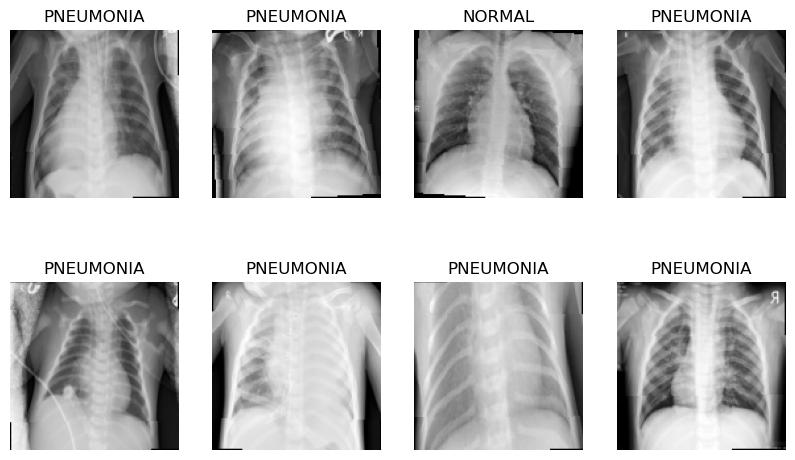

In [10]:
# ===========================
# STEP 5: Visualize some images
# ===========================
def imshow_batch(images, labels, classes):
    plt.figure(figsize=(10, 6))
    for i in range(min(8, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # unnormalize
        
        plt.subplot(2, 4, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()

# get first batch
images, labels = next(iter(orig_train_dl))
imshow_batch(images, labels, orig_train_ds.classes)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # input: grayscale
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # after 3 pool layers from 128→16
        self.fc2 = nn.Linear(128, 2)             # 2 classes: NORMAL / PNEUMONIA

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 128→64
        x = self.pool(F.relu(self.conv2(x)))   # 64→32
        x = self.pool(F.relu(self.conv3(x)))   # 32→16
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
import torch.optim as optim

def train_model(model, train_loader, epochs=5, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    return model

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, test_loader):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # PNEUMONIA prob
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
            all_probs.extend(probs.numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    return acc, prec, rec, f1, auc, all_labels, all_preds, all_probs

### Train Original and Test on Others

In [15]:
# ---- Load datasets ----
train_ds, train_dl = load_dataset("original", "train", train_transforms, shuffle=True)
test_orig_ds, test_orig_dl = load_dataset("original", "test", test_transforms)
test_gans_ds, test_gans_dl = load_dataset("gans", "test", test_transforms)
test_vaes_ds, test_vaes_dl = load_dataset("vaes", "test", test_transforms)

# ---- Initialize model ----
model = SmallCNN()

# ---- Train model ----
model = train_model(model, train_dl, epochs=5)

# ---- Evaluate on original, gans, vaes ----
metrics_orig = evaluate_model(model, test_orig_dl)
metrics_gans = evaluate_model(model, test_gans_dl)
metrics_vaes = evaluate_model(model, test_vaes_dl)

print("Original → Original:", metrics_orig[:5])
print("Original → GANs:", metrics_gans[:5])
print("Original → VAEs:", metrics_vaes[:5])

Epoch 1/5 - Loss: 0.2239
Epoch 2/5 - Loss: 0.1169
Epoch 3/5 - Loss: 0.1006
Epoch 4/5 - Loss: 0.0834
Epoch 5/5 - Loss: 0.0802
Original → Original: (0.7660256410256411, 0.7310606060606061, 0.9897435897435898, 0.840958605664488, 0.9287639710716633)
Original → GANs: (0.9633333333333334, 0.9469453376205788, 0.9816666666666667, 0.9639934533551555, 0.9921777777777778)
Original → VAEs: (0.8588235294117647, 0.8260869565217391, 1.0, 0.9047619047619048, 0.9931077694235588)


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.dpi": 300,
    "savefig.dpi": 300,
})


# Create folder for results
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def plot_metrics_bar(metrics_dict, save_name="metrics_bar"):
    """
    metrics_dict: {"Original": (acc, prec, rec, f1), ...}
    Bar chart with bold internal labels, suitable for LaTeX papers.
    Saved as both PNG and PDF.
    """
    metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
    datasets = list(metrics_dict.keys())
    
    values = np.array([metrics_dict[d][:4] for d in datasets]) * 100

    # Colorblind-safe, professional palette
    colors = sns.color_palette("colorblind", n_colors=len(datasets))

    x = np.arange(len(metrics_names))
    width = 0.22

    fig, ax = plt.subplots(figsize=(9, 4.5))

    for i, dataset in enumerate(datasets):
        bars = ax.bar(
            x + i*width - width,
            values[i],
            width=width,
            label=dataset,
            color=colors[i]
        )

        # Bold labels inside bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height - 4,
                f"{height:.0f}",
                ha="center",
                va="top",
                color="white",
                fontsize=11,
                fontweight="bold"
            )

    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.set_ylabel("Score (%)")
    ax.set_ylim(0, 105)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(datasets),
        frameon=False
    )
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    fig.tight_layout()

    # Save both PNG and PDF
    fig.savefig(os.path.join(RESULTS_DIR, f"{save_name}.png"), bbox_inches="tight")
    fig.savefig(os.path.join(RESULTS_DIR, f"{save_name}.pdf"), bbox_inches="tight")

    plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix", save_name="confusion_matrix"):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4.5, 4))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=classes,
        yticklabels=classes,
        annot_kws={"fontsize": 12, "fontweight": "bold"},
        ax=ax
    )

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    
    fig.tight_layout()

    # Save both PNG and PDF
    fig.savefig(os.path.join(RESULTS_DIR, f"{save_name}.png"), bbox_inches="tight")
    fig.savefig(os.path.join(RESULTS_DIR, f"{save_name}.pdf"), bbox_inches="tight")

    plt.show()

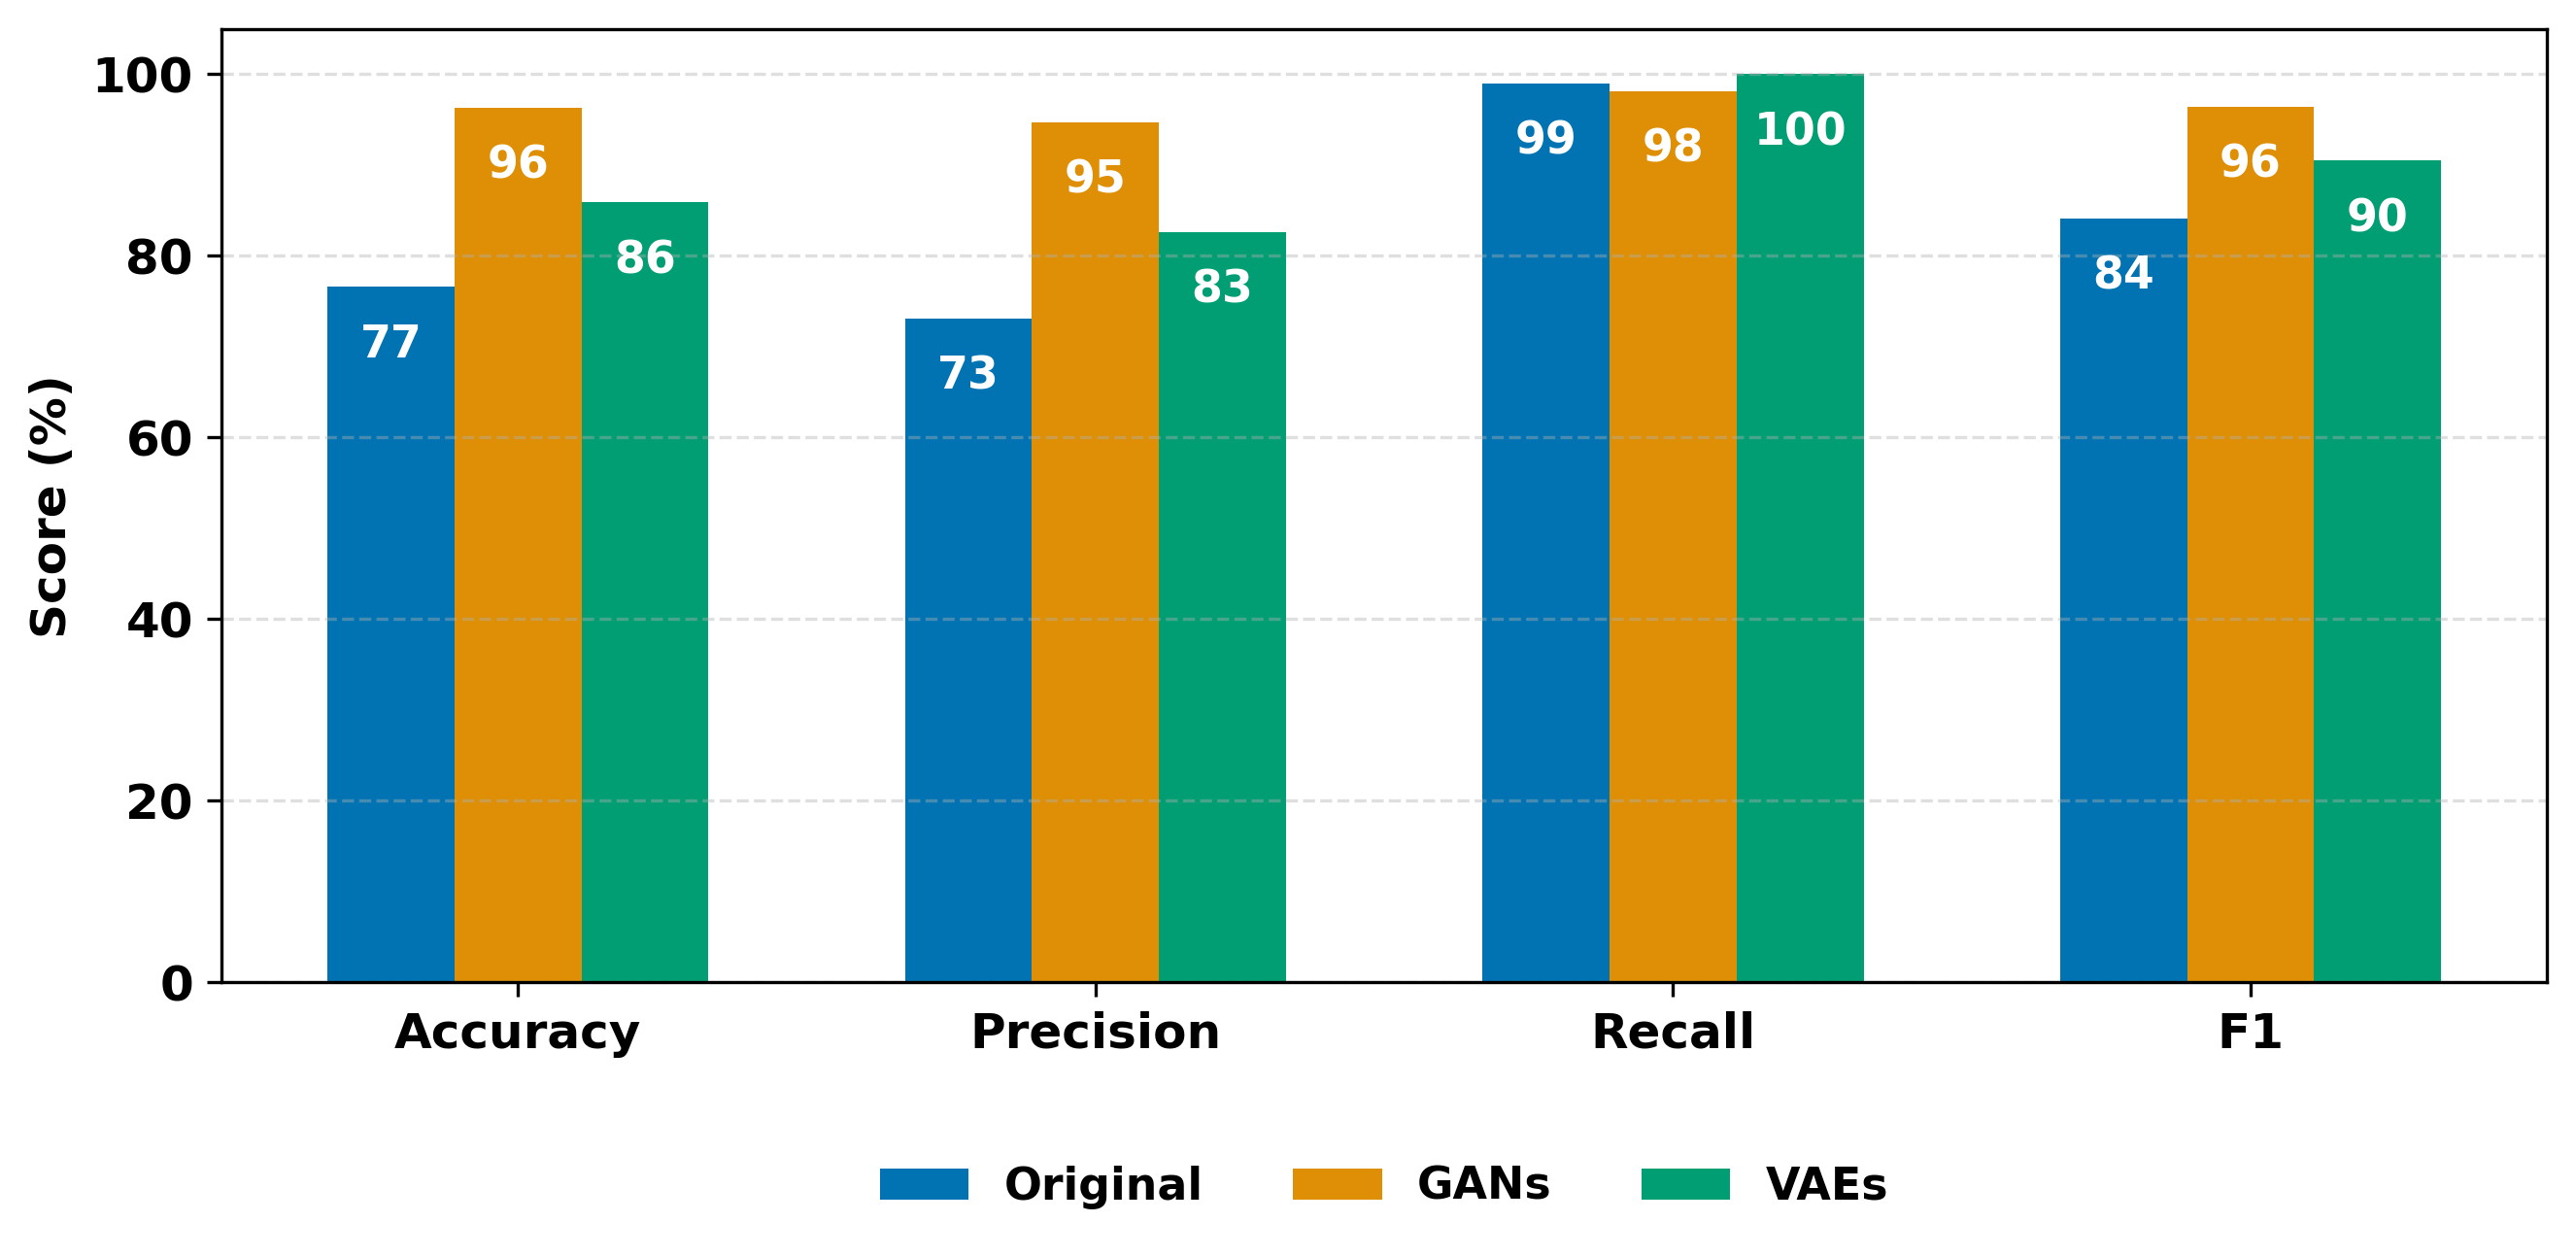

In [18]:
metrics_dict = {
    "Original": metrics_orig[:5],
    "GANs": metrics_gans[:5],
    "VAEs": metrics_vaes[:5]
}

plot_metrics_bar(metrics_dict, save_name="train_original")

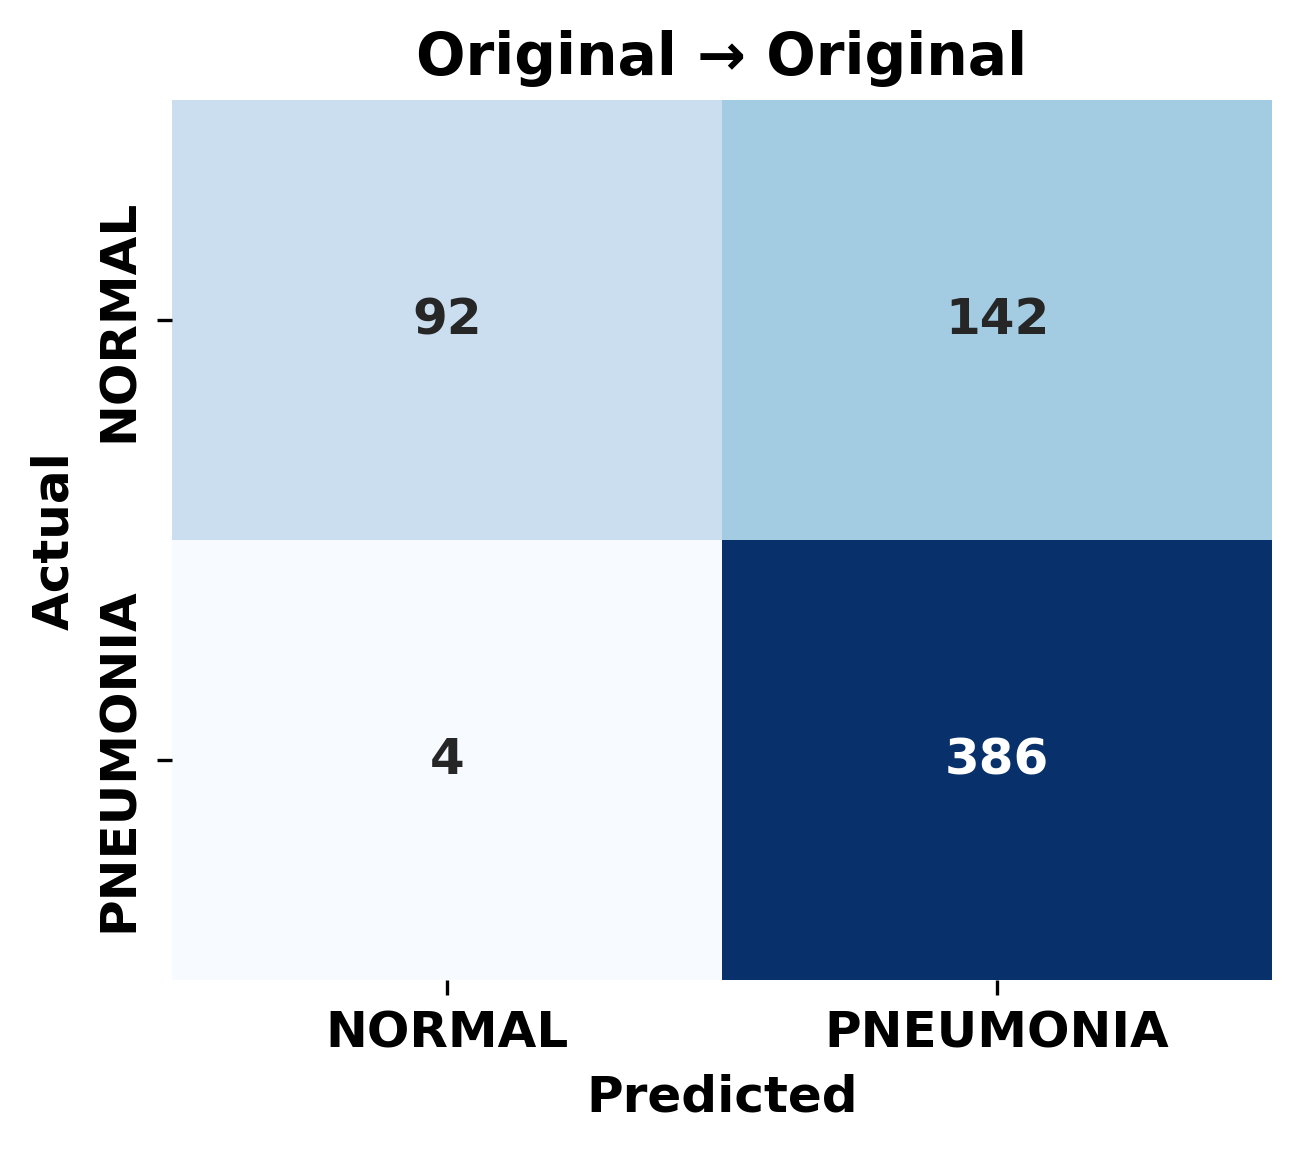

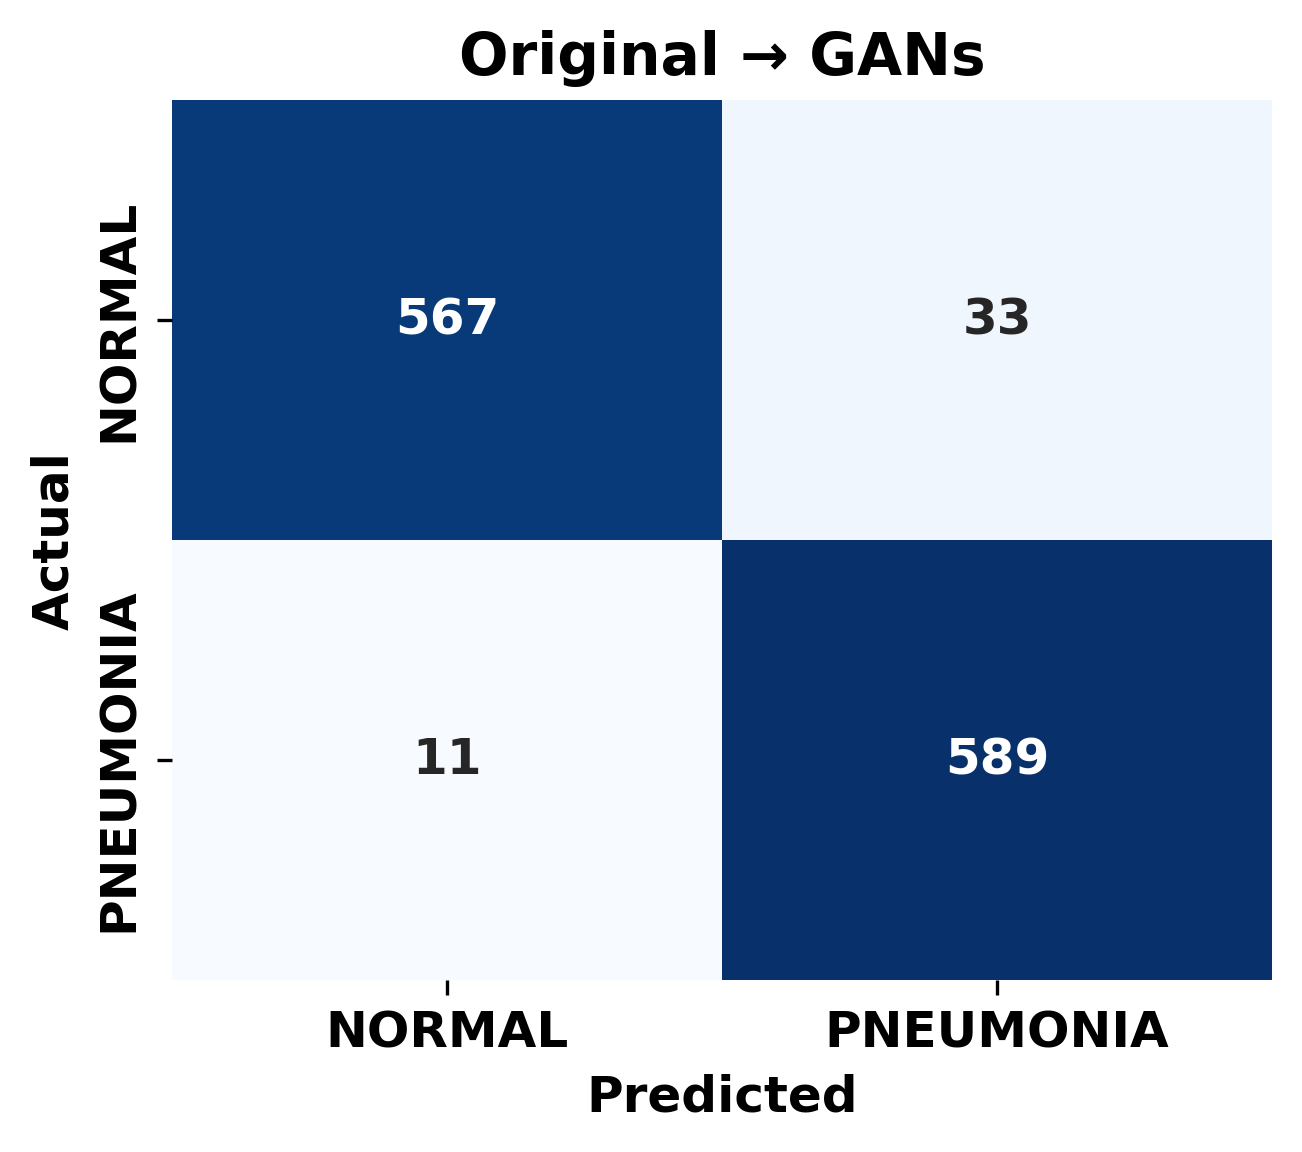

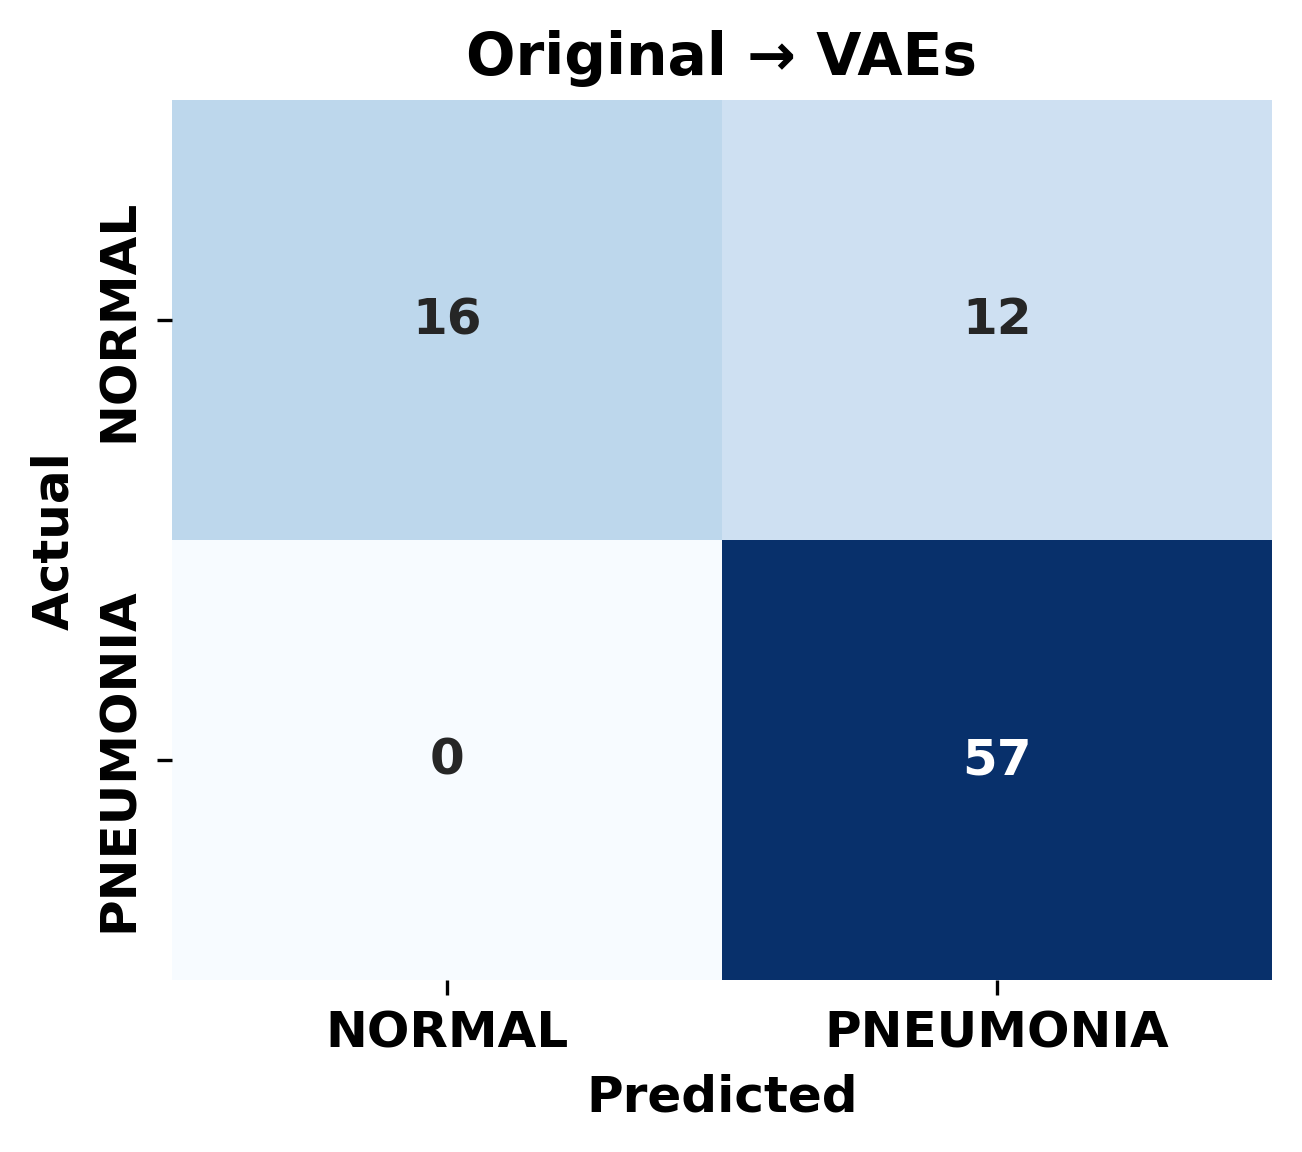

In [19]:
# Confusion matrices
plot_confusion_matrix(metrics_orig[5], metrics_orig[6], train_ds.classes, title="Original → Original", save_name="Original_Original_CM")
plot_confusion_matrix(metrics_gans[5], metrics_gans[6], train_ds.classes, title="Original → GANs", save_name="Original_GANs_CM")
plot_confusion_matrix(metrics_vaes[5], metrics_vaes[6], train_ds.classes, title="Original → VAEs", save_name="Original_VAEs_CM")

### Train GANs and Test on others

In [21]:
# ---- Load datasets ----
train_ds, train_dl = load_dataset("gans", "train", train_transforms, shuffle=True)
test_orig_ds, test_orig_dl = load_dataset("original", "test", test_transforms)
test_gans_ds, test_gans_dl = load_dataset("gans", "test", test_transforms)
test_vaes_ds, test_vaes_dl = load_dataset("vaes", "test", test_transforms)

# ---- Initialize model ----
model = SmallCNN()

# ---- Train model ----
model = train_model(model, train_dl, epochs=5)

# ---- Evaluate on original, gans, vaes ----
metrics_orig = evaluate_model(model, test_orig_dl)
metrics_gans = evaluate_model(model, test_gans_dl)
metrics_vaes = evaluate_model(model, test_vaes_dl)

print("GANs → Original:", metrics_orig[:5])
print("GANs → GANs:", metrics_gans[:5])
print("GANs → VAEs:", metrics_vaes[:5])

Epoch 1/5 - Loss: 0.0962
Epoch 2/5 - Loss: 0.0276
Epoch 3/5 - Loss: 0.0101
Epoch 4/5 - Loss: 0.0163
Epoch 5/5 - Loss: 0.0153
GANs → Original: (0.6778846153846154, 0.6609880749574105, 0.9948717948717949, 0.7942681678607983, 0.8215757177295638)
GANs → GANs: (0.9991666666666666, 0.9983361064891847, 1.0, 0.9991673605328892, 1.0)
GANs → VAEs: (0.7294117647058823, 0.7125, 1.0, 0.8321167883211679, 0.7954260651629073)


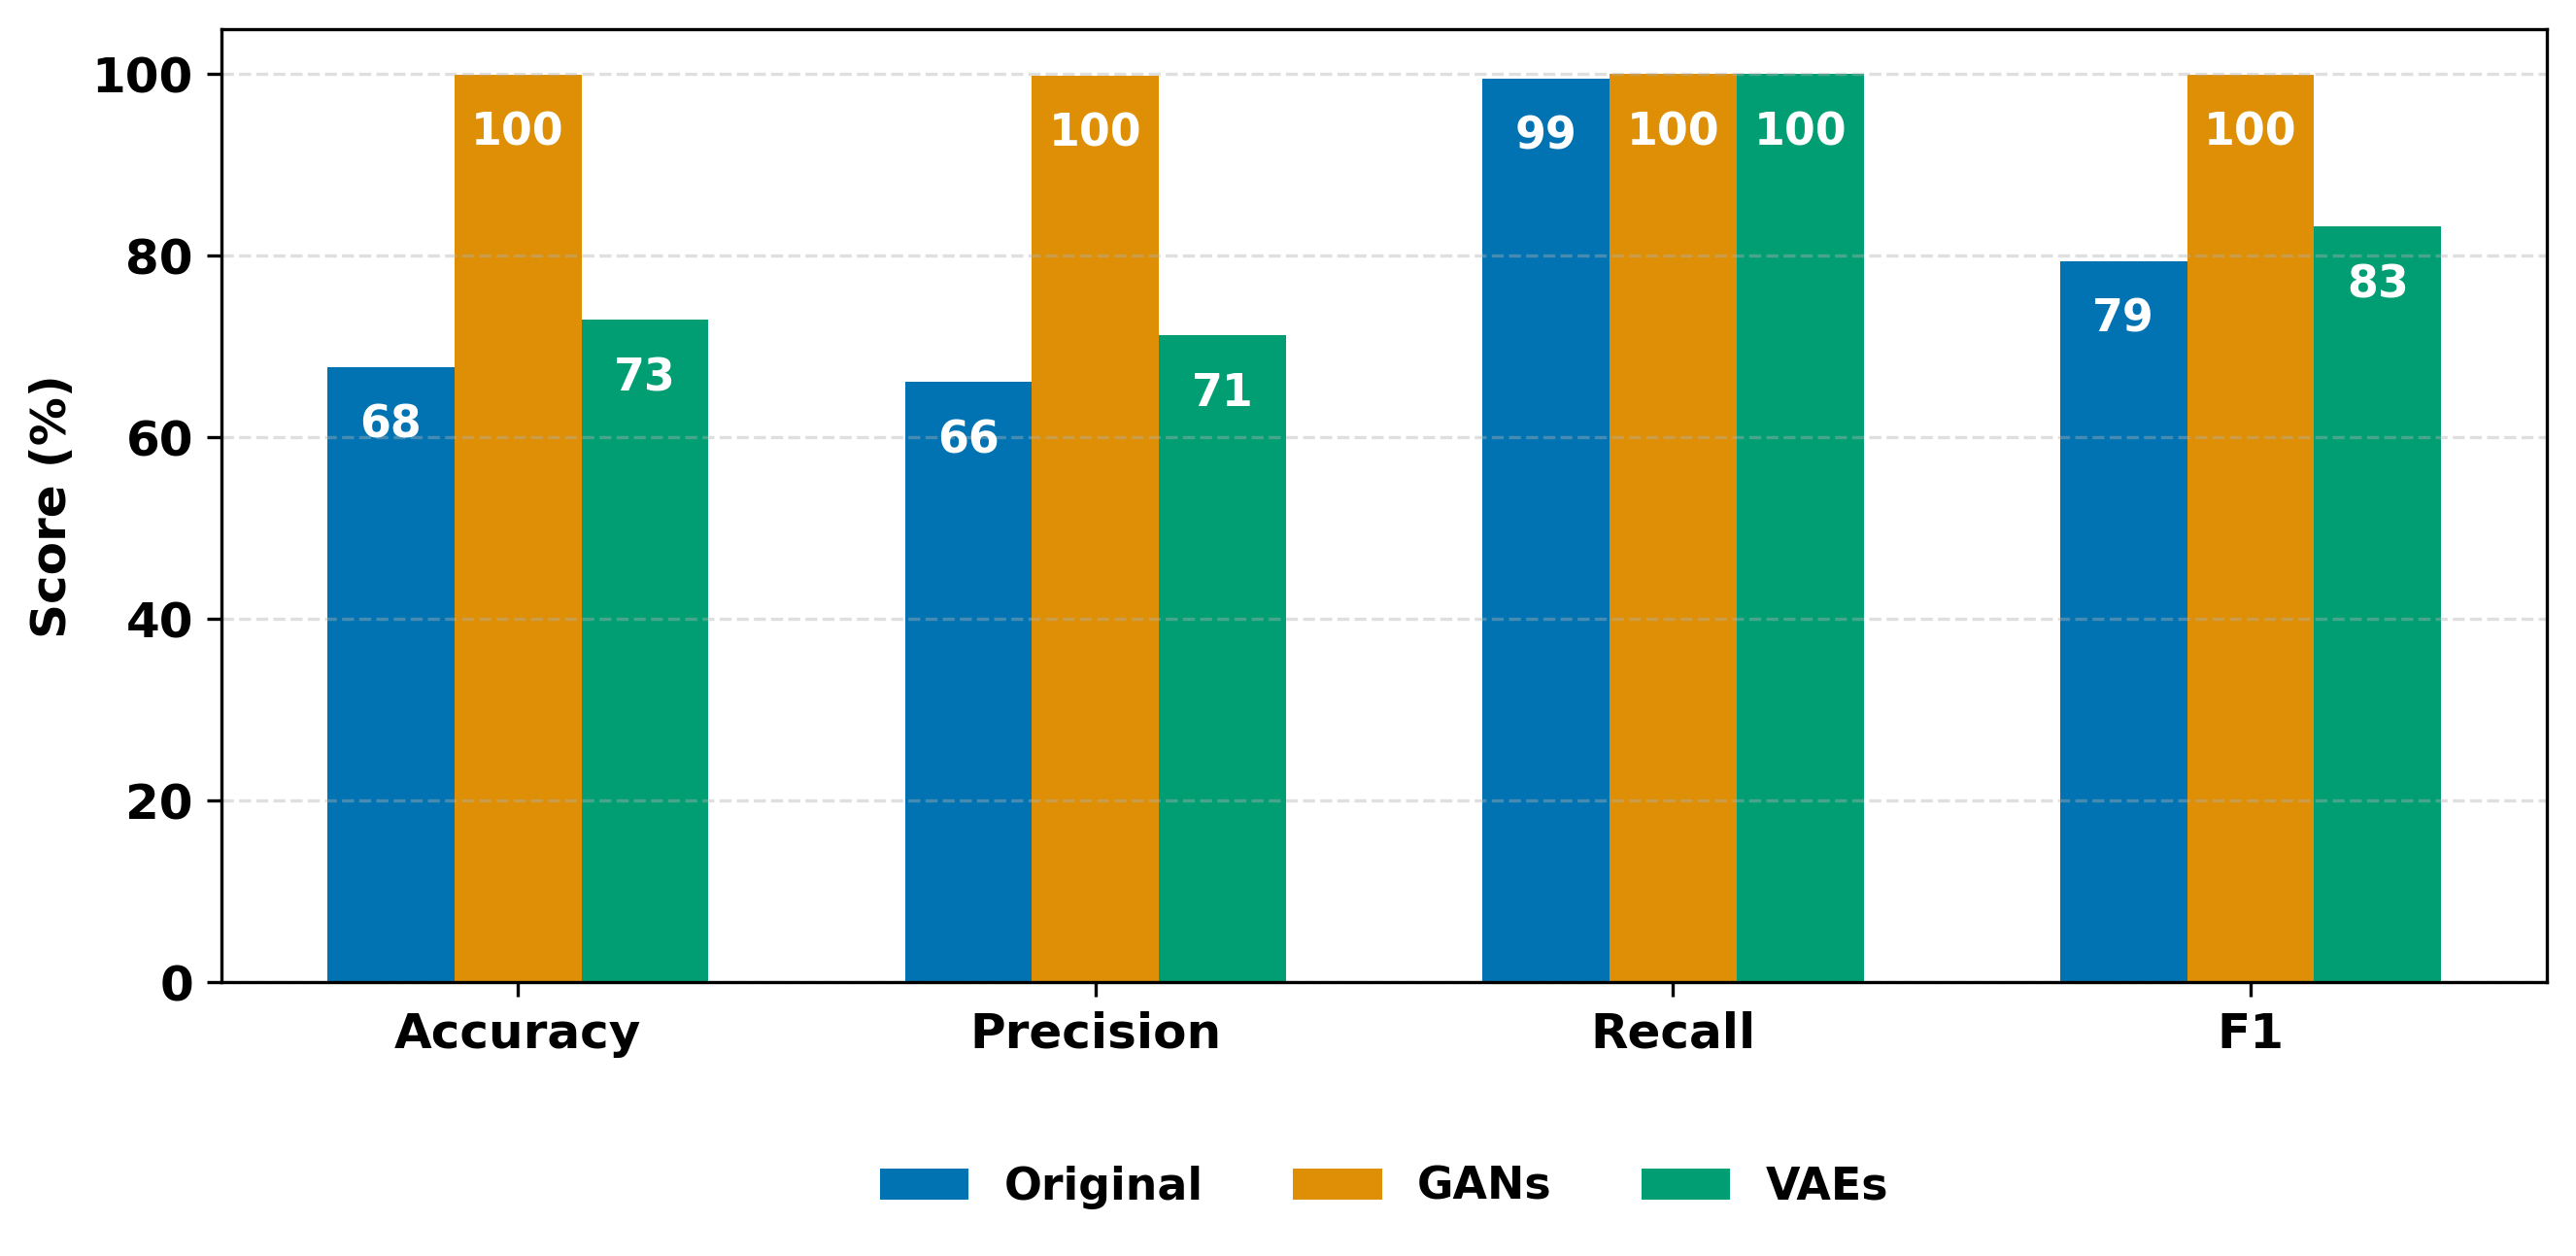

In [22]:
metrics_dict = {
    "Original": metrics_orig[:5],
    "GANs": metrics_gans[:5],
    "VAEs": metrics_vaes[:5]
}

plot_metrics_bar(metrics_dict, save_name="train_GANs")

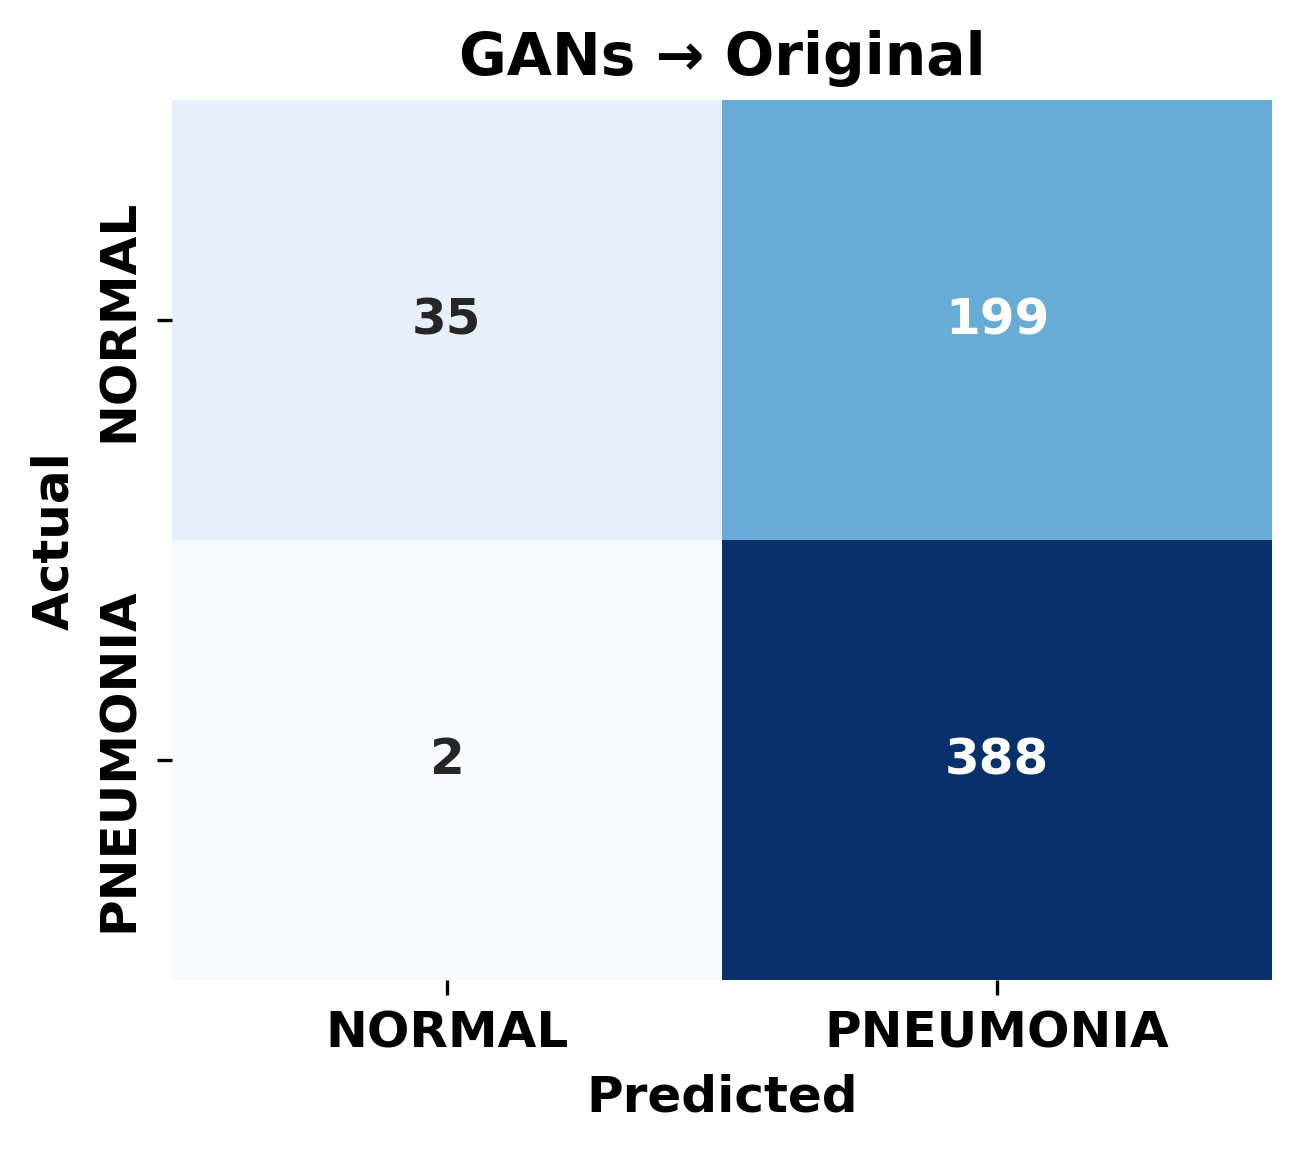

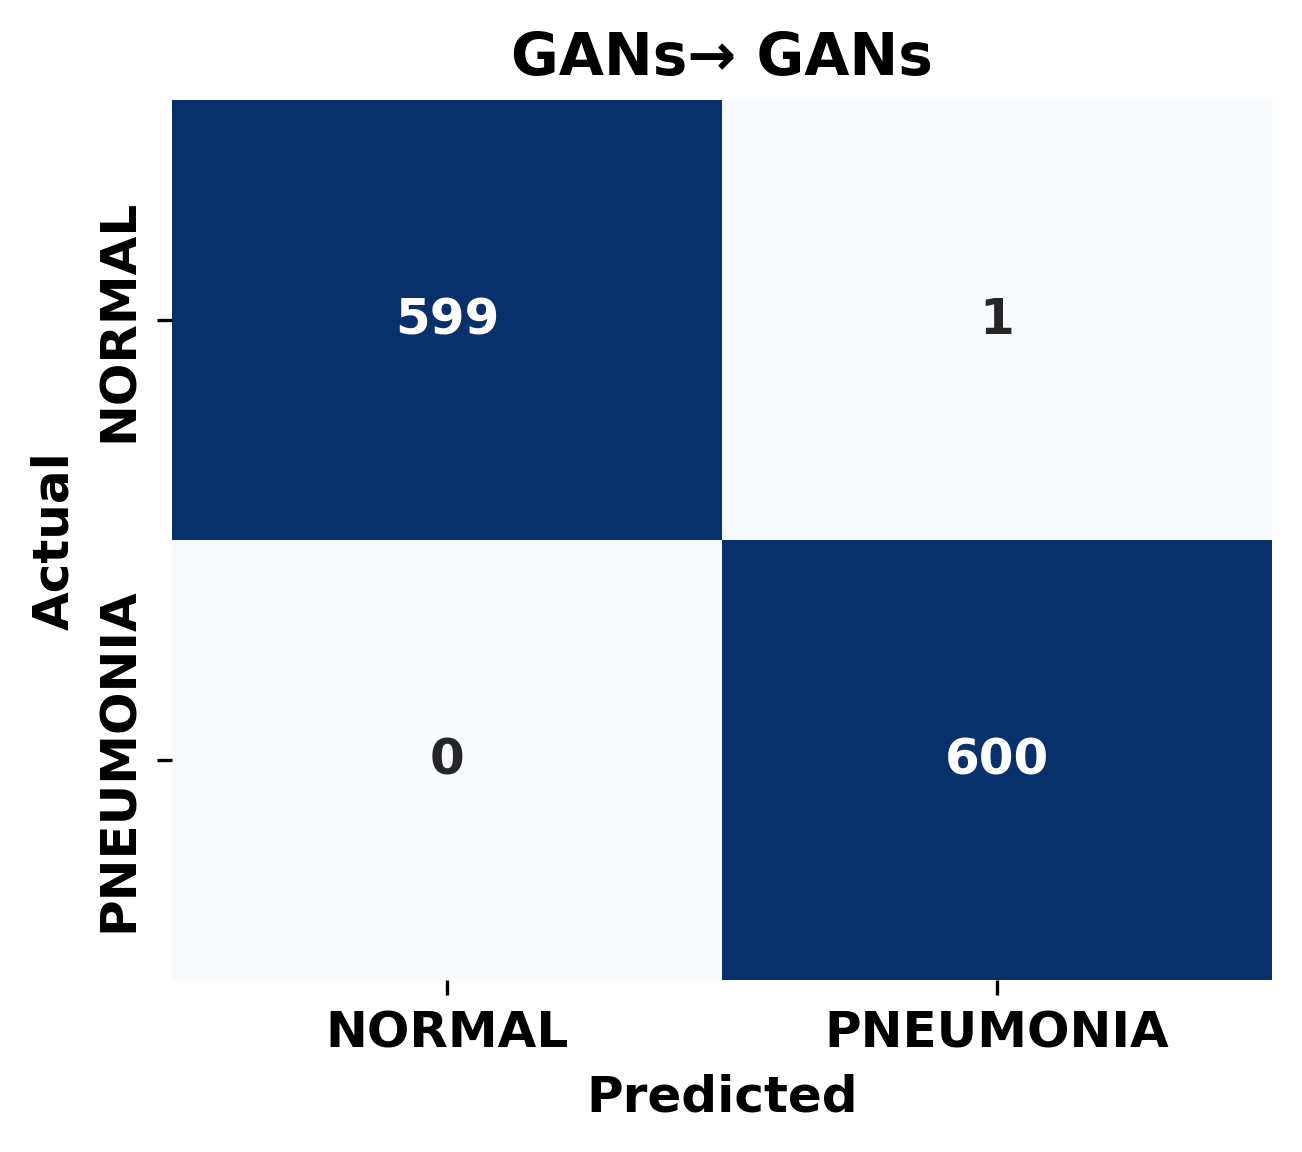

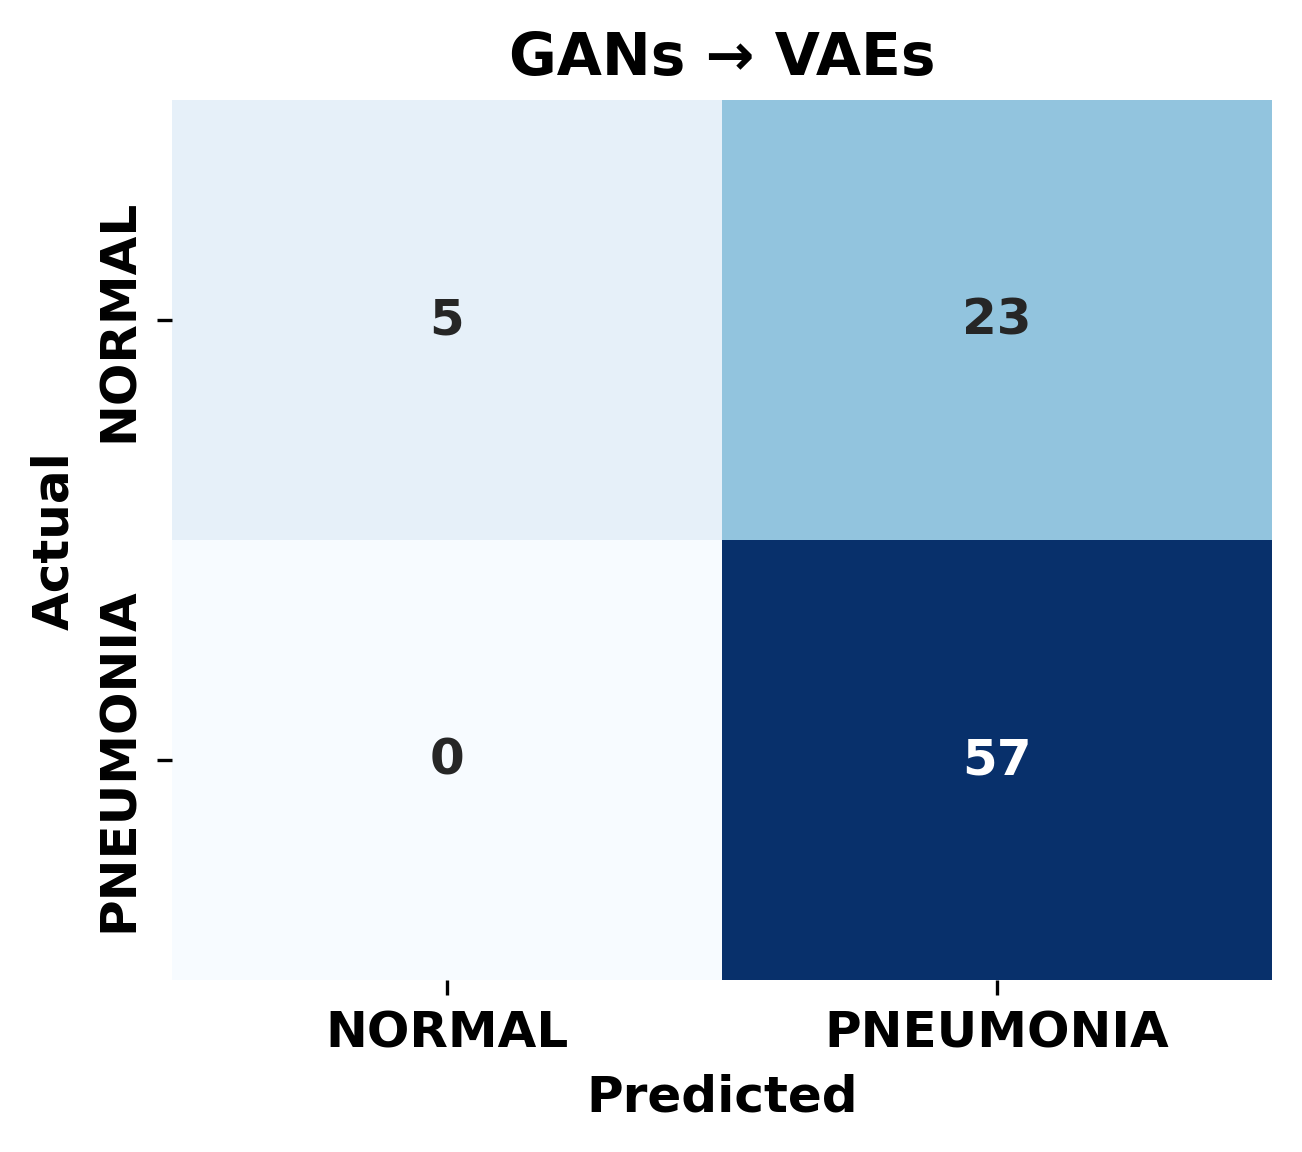

In [23]:
# Confusion matrices
plot_confusion_matrix(metrics_orig[5], metrics_orig[6], train_ds.classes, title="GANs → Original", save_name="GANs_Original_CM")
plot_confusion_matrix(metrics_gans[5], metrics_gans[6], train_ds.classes, title="GANs→ GANs", save_name="GANs_GANs_CM")
plot_confusion_matrix(metrics_vaes[5], metrics_vaes[6], train_ds.classes, title="GANs → VAEs", save_name="GANs_VAEs_CM")

### Train VAEs and Test on others

In [25]:
# ---- Load datasets ----
train_ds, train_dl = load_dataset("vaes", "train", train_transforms, shuffle=True)
test_orig_ds, test_orig_dl = load_dataset("original", "test", test_transforms)
test_gans_ds, test_gans_dl = load_dataset("gans", "test", test_transforms)
test_vaes_ds, test_vaes_dl = load_dataset("vaes", "test", test_transforms)

# ---- Initialize model ----
model = SmallCNN()

# ---- Train model ----
model = train_model(model, train_dl, epochs=5)

# ---- Evaluate on original, gans, vaes ----
metrics_orig = evaluate_model(model, test_orig_dl)
metrics_gans = evaluate_model(model, test_gans_dl)
metrics_vaes = evaluate_model(model, test_vaes_dl)

print("VAEs → Original:", metrics_orig[:5])
print("VAEs → GANs:", metrics_gans[:5])
print("VAEs → VAEs:", metrics_vaes[:5])

Epoch 1/5 - Loss: 0.6060
Epoch 2/5 - Loss: 0.3300
Epoch 3/5 - Loss: 0.2346
Epoch 4/5 - Loss: 0.1746
Epoch 5/5 - Loss: 0.1689
VAEs → Original: (0.8413461538461539, 0.8375870069605569, 0.9256410256410257, 0.879415347137637, 0.9084593469208855)
VAEs → GANs: (0.96, 0.9408945686900958, 0.9816666666666667, 0.9608482871125612, 0.9903819444444445)
VAEs → VAEs: (0.9529411764705882, 0.9491525423728814, 0.9824561403508771, 0.9655172413793104, 0.9937343358395989)


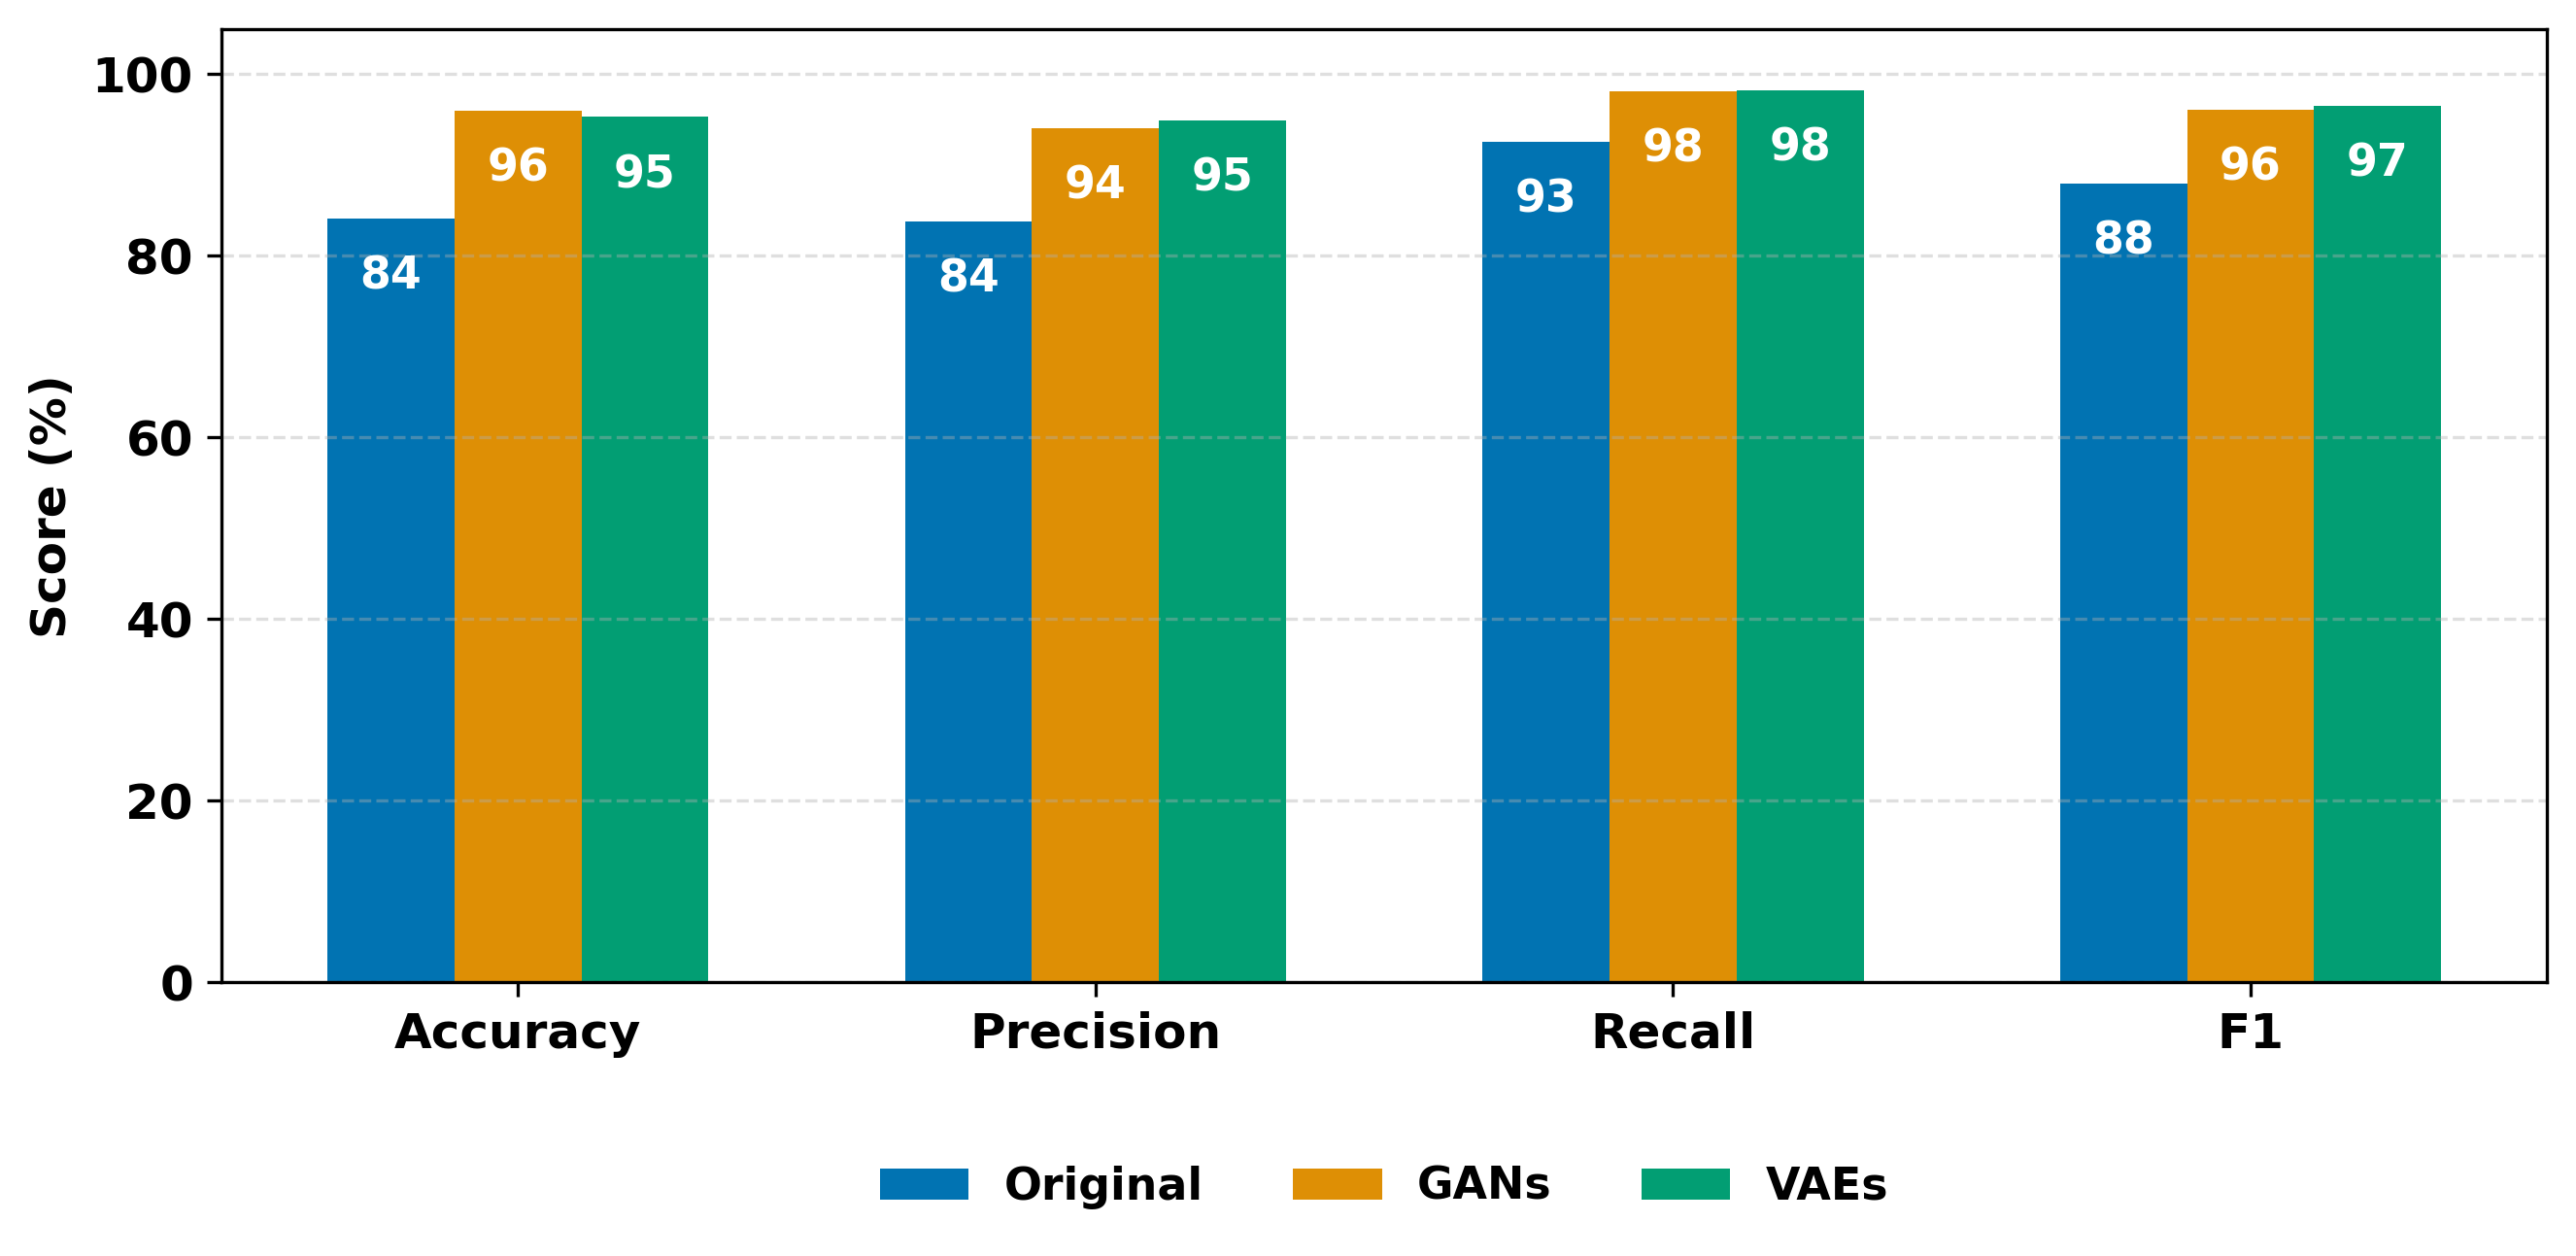

In [26]:
metrics_dict = {
    "Original": metrics_orig[:5],
    "GANs": metrics_gans[:5],
    "VAEs": metrics_vaes[:5]
}

plot_metrics_bar(metrics_dict, save_name="train_VAEs")

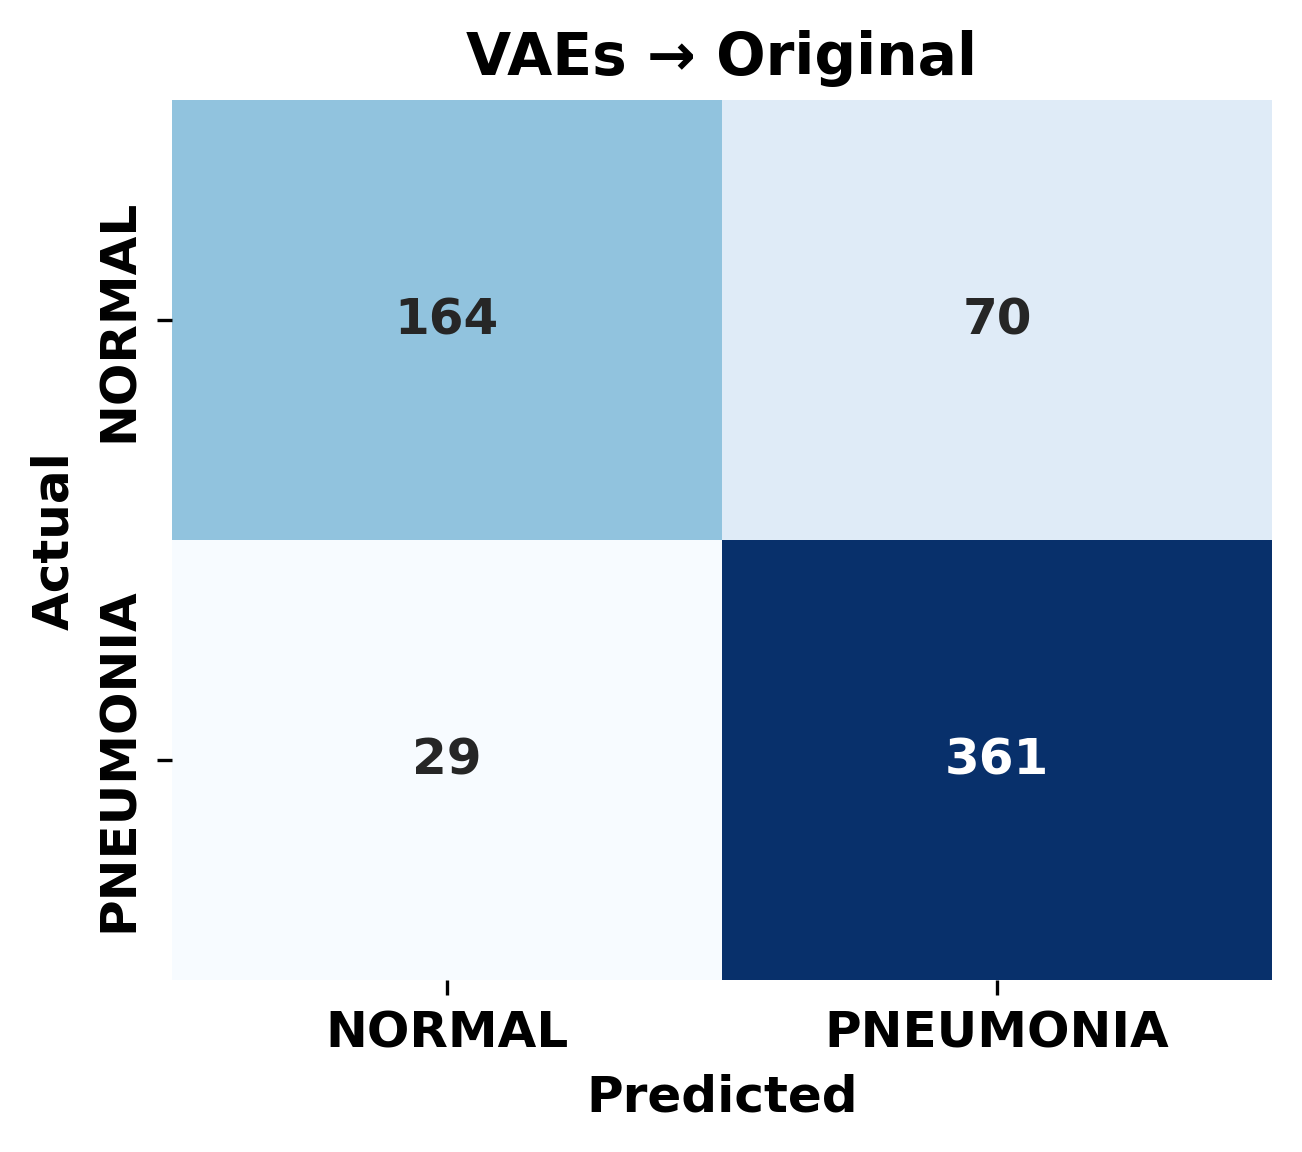

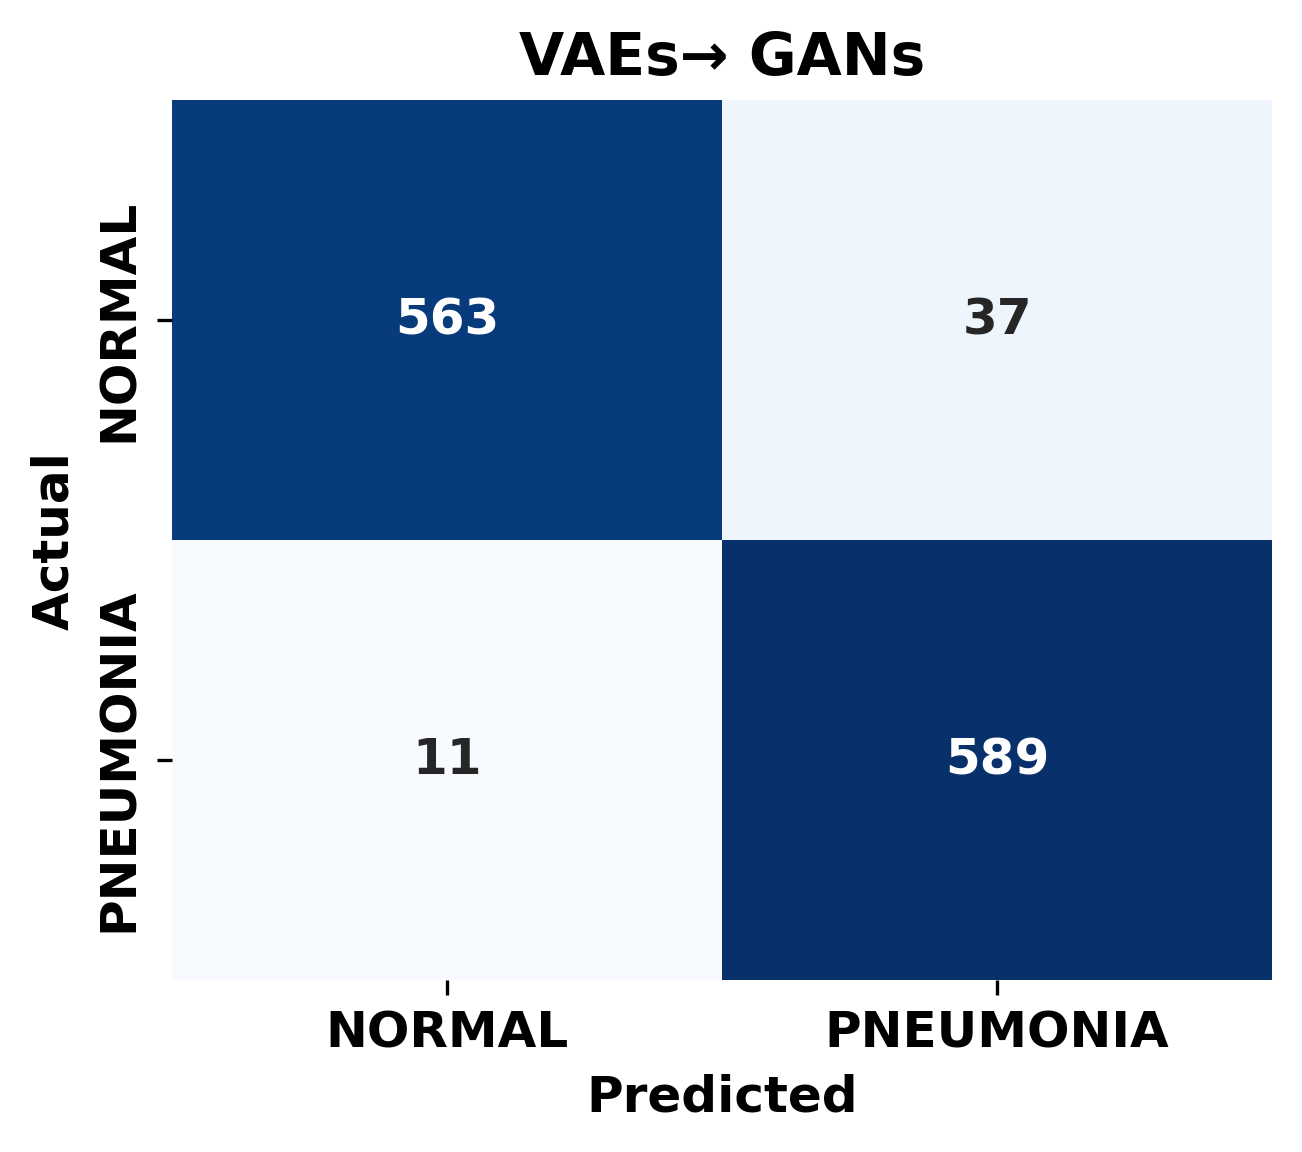

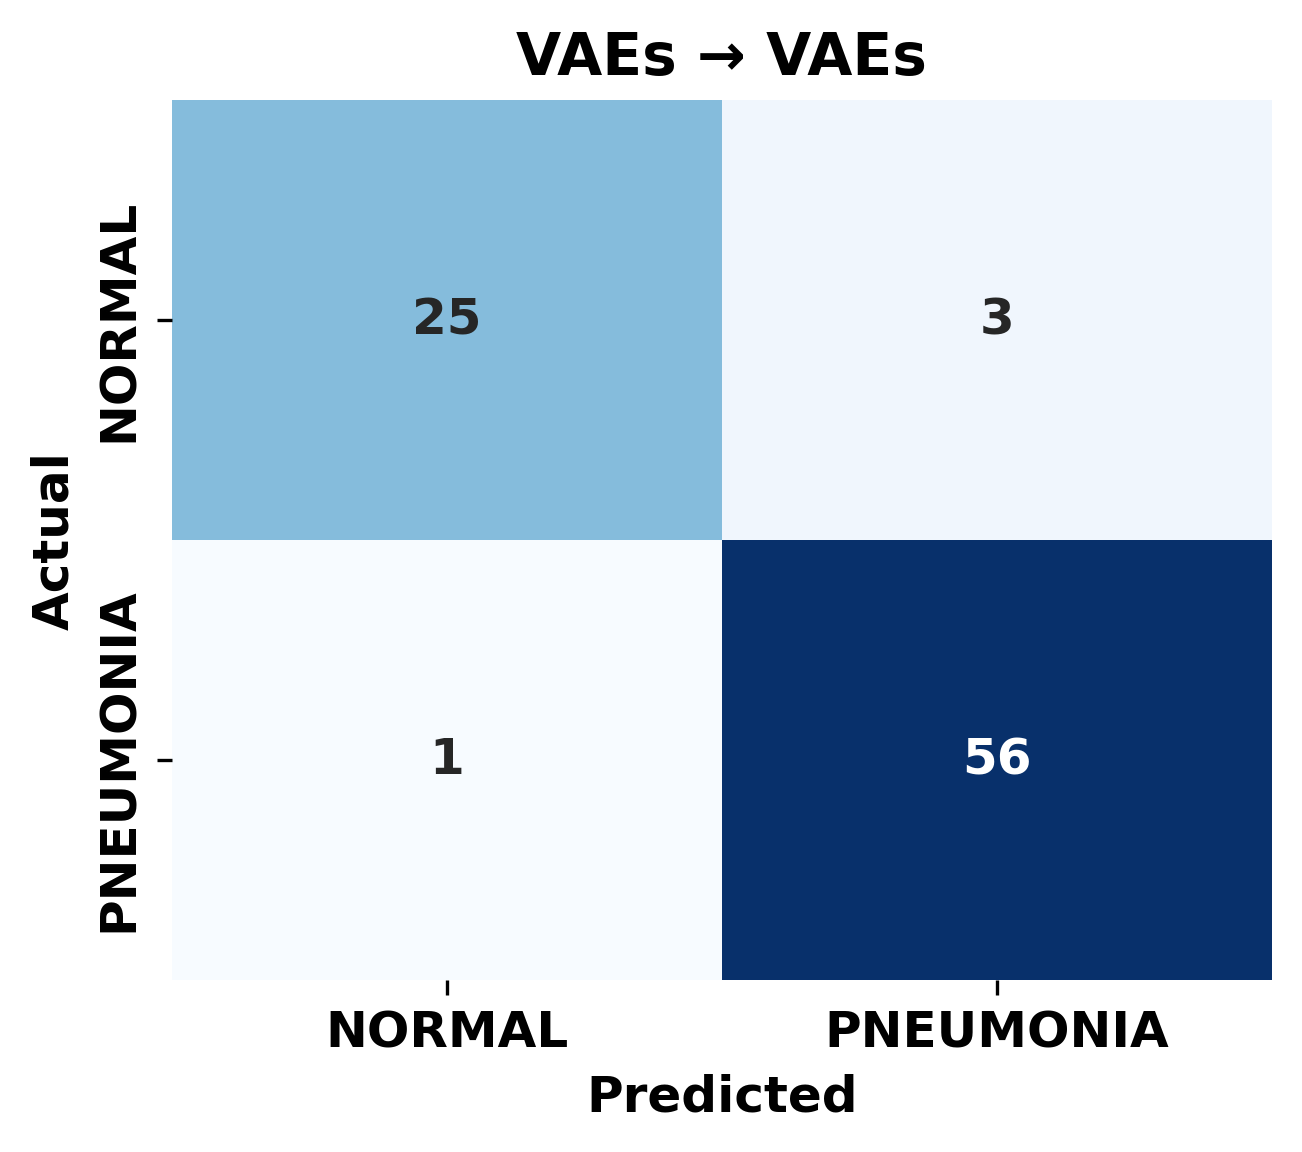

In [27]:
# Confusion matrices
plot_confusion_matrix(metrics_orig[5], metrics_orig[6], train_ds.classes, title="VAEs → Original", save_name="VAEs_Original_CM")
plot_confusion_matrix(metrics_gans[5], metrics_gans[6], train_ds.classes, title="VAEs→ GANs", save_name="VAEs_GANs_CM")
plot_confusion_matrix(metrics_vaes[5], metrics_vaes[6], train_ds.classes, title="VAEs → VAEs", save_name="VAEs_VAEs_CM")

### Train with Mixed

In [29]:
# ---- Load datasets ----
train_ds, train_dl = load_dataset("mixed", "train", train_transforms, shuffle=True)
test_orig_ds, test_orig_dl = load_dataset("original", "test", test_transforms)
test_gans_ds, test_gans_dl = load_dataset("gans", "test", test_transforms)
test_vaes_ds, test_vaes_dl = load_dataset("vaes", "test", test_transforms)

# ---- Initialize model ----
model = SmallCNN()

# ---- Train model ----
model = train_model(model, train_dl, epochs=5)

# ---- Evaluate on original, gans, vaes ----
metrics_orig = evaluate_model(model, test_orig_dl)
metrics_gans = evaluate_model(model, test_gans_dl)
metrics_vaes = evaluate_model(model, test_vaes_dl)

print("Mixed → Original:", metrics_orig[:5])
print("Mixed → GANs:", metrics_gans[:5])
print("Mixed → VAEs:", metrics_vaes[:5])

Epoch 1/5 - Loss: 0.1468
Epoch 2/5 - Loss: 0.0758
Epoch 3/5 - Loss: 0.0667
Epoch 4/5 - Loss: 0.0579
Epoch 5/5 - Loss: 0.0489
Mixed → Original: (0.7836538461538461, 0.7485380116959064, 0.9846153846153847, 0.8504983388704319, 0.9206771860618014)
Mixed → GANs: (0.9983333333333333, 1.0, 0.9966666666666667, 0.998330550918197, 1.0)
Mixed → VAEs: (0.9294117647058824, 0.9047619047619048, 1.0, 0.95, 0.9868421052631579)


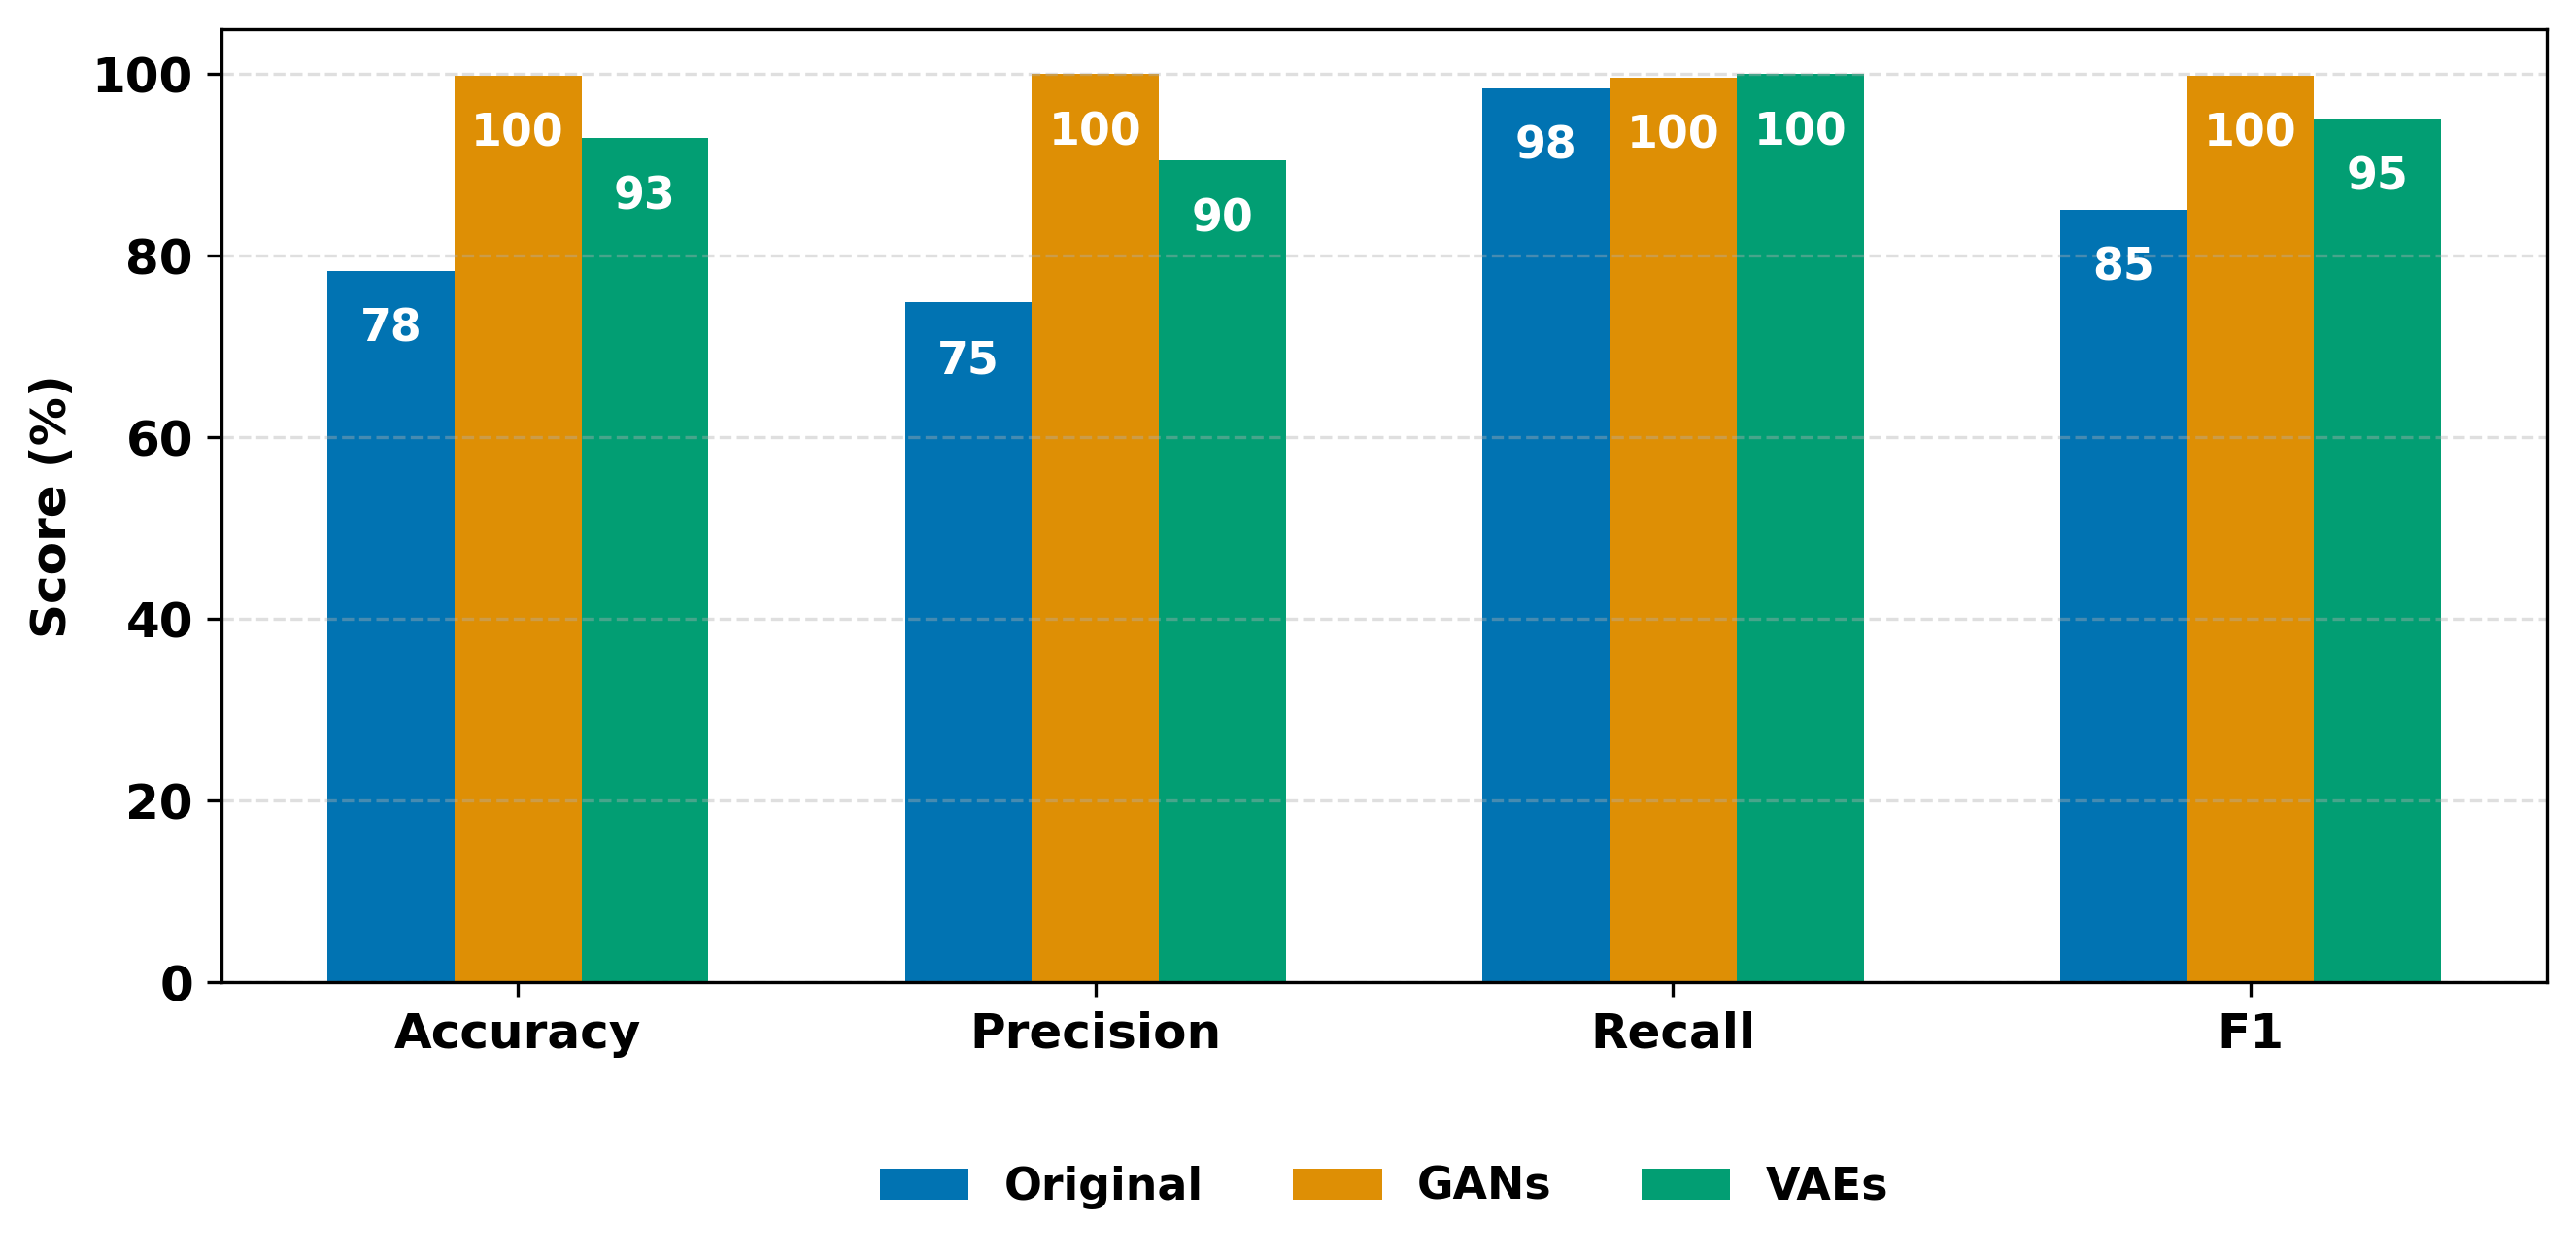

In [30]:
metrics_dict = {
    "Original": metrics_orig[:5],
    "GANs": metrics_gans[:5],
    "VAEs": metrics_vaes[:5]
}

plot_metrics_bar(metrics_dict, save_name="train_mixed")

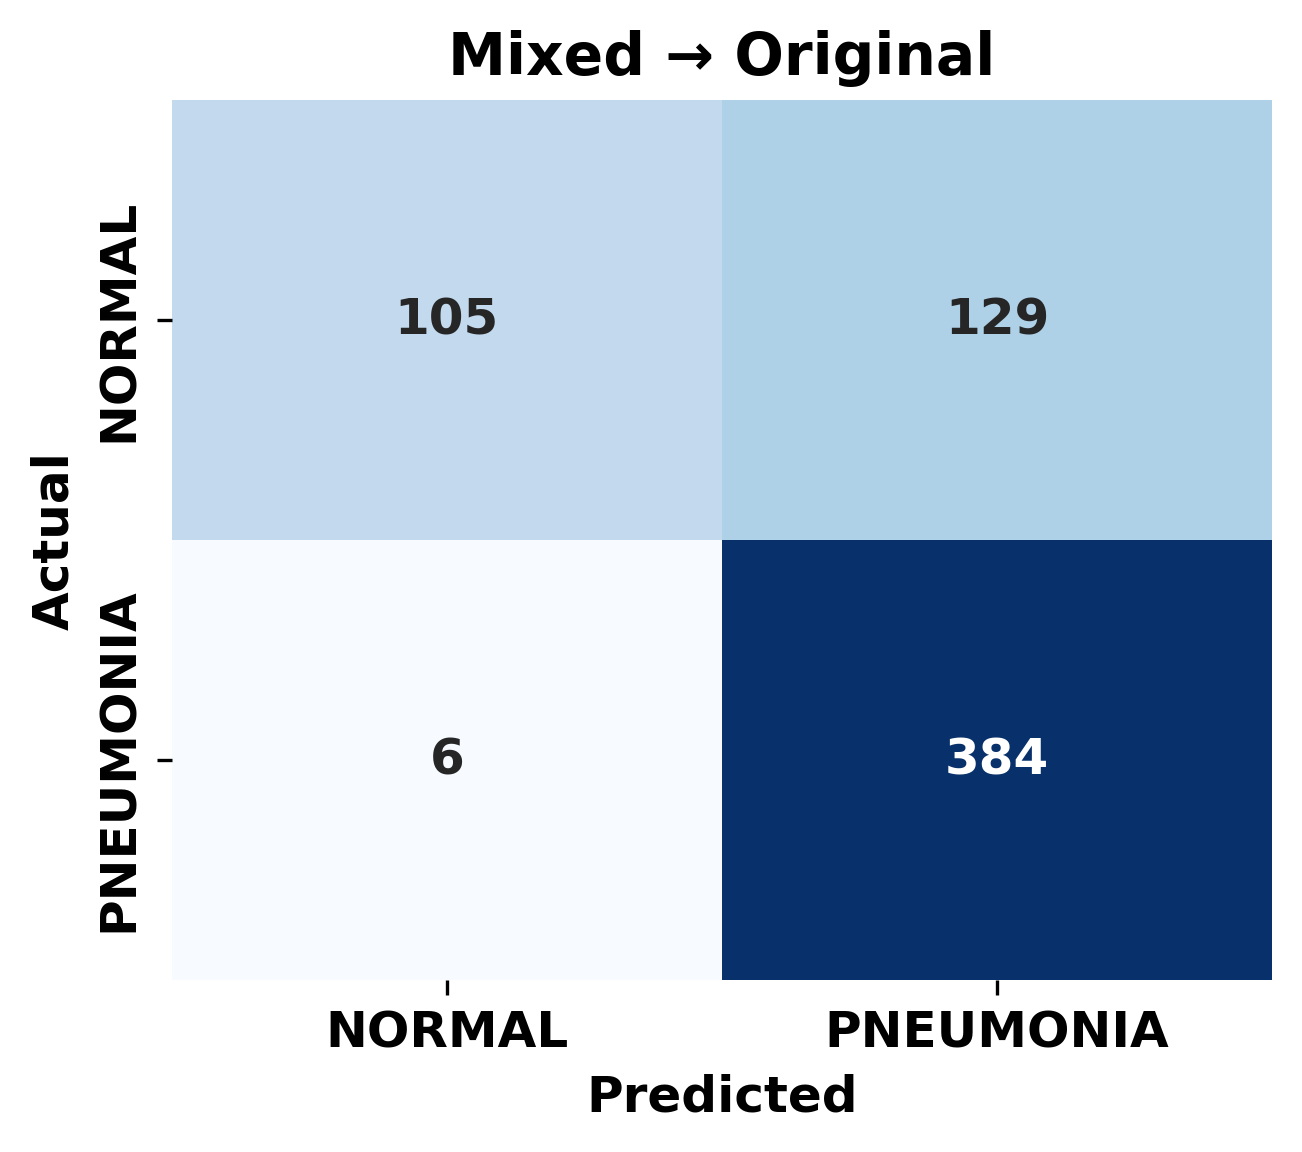

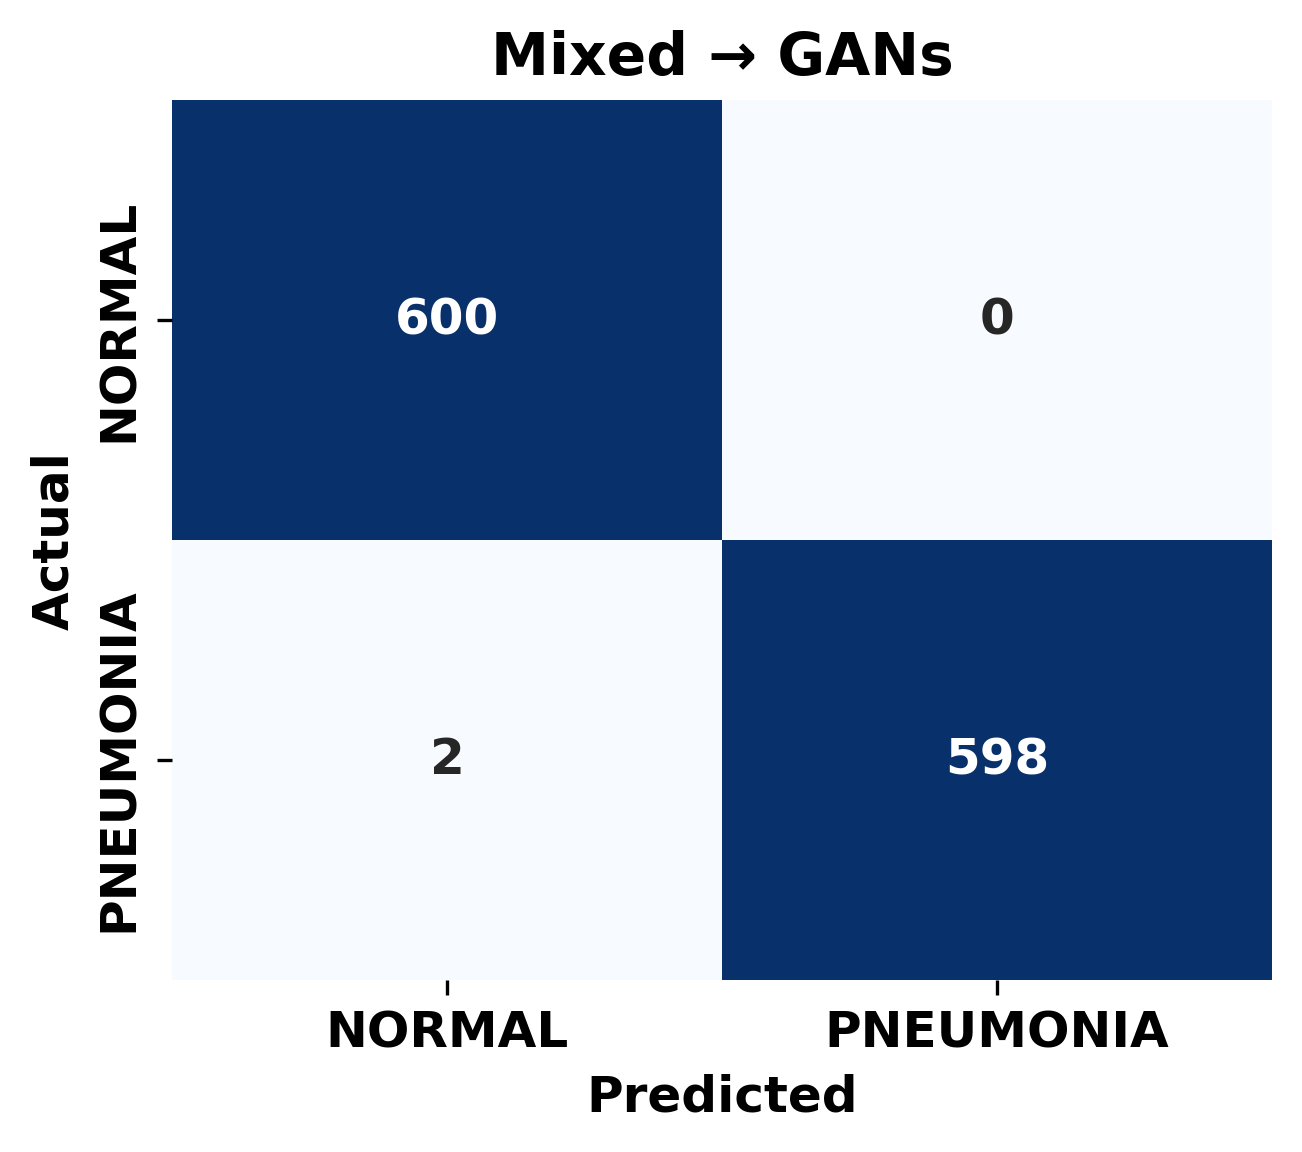

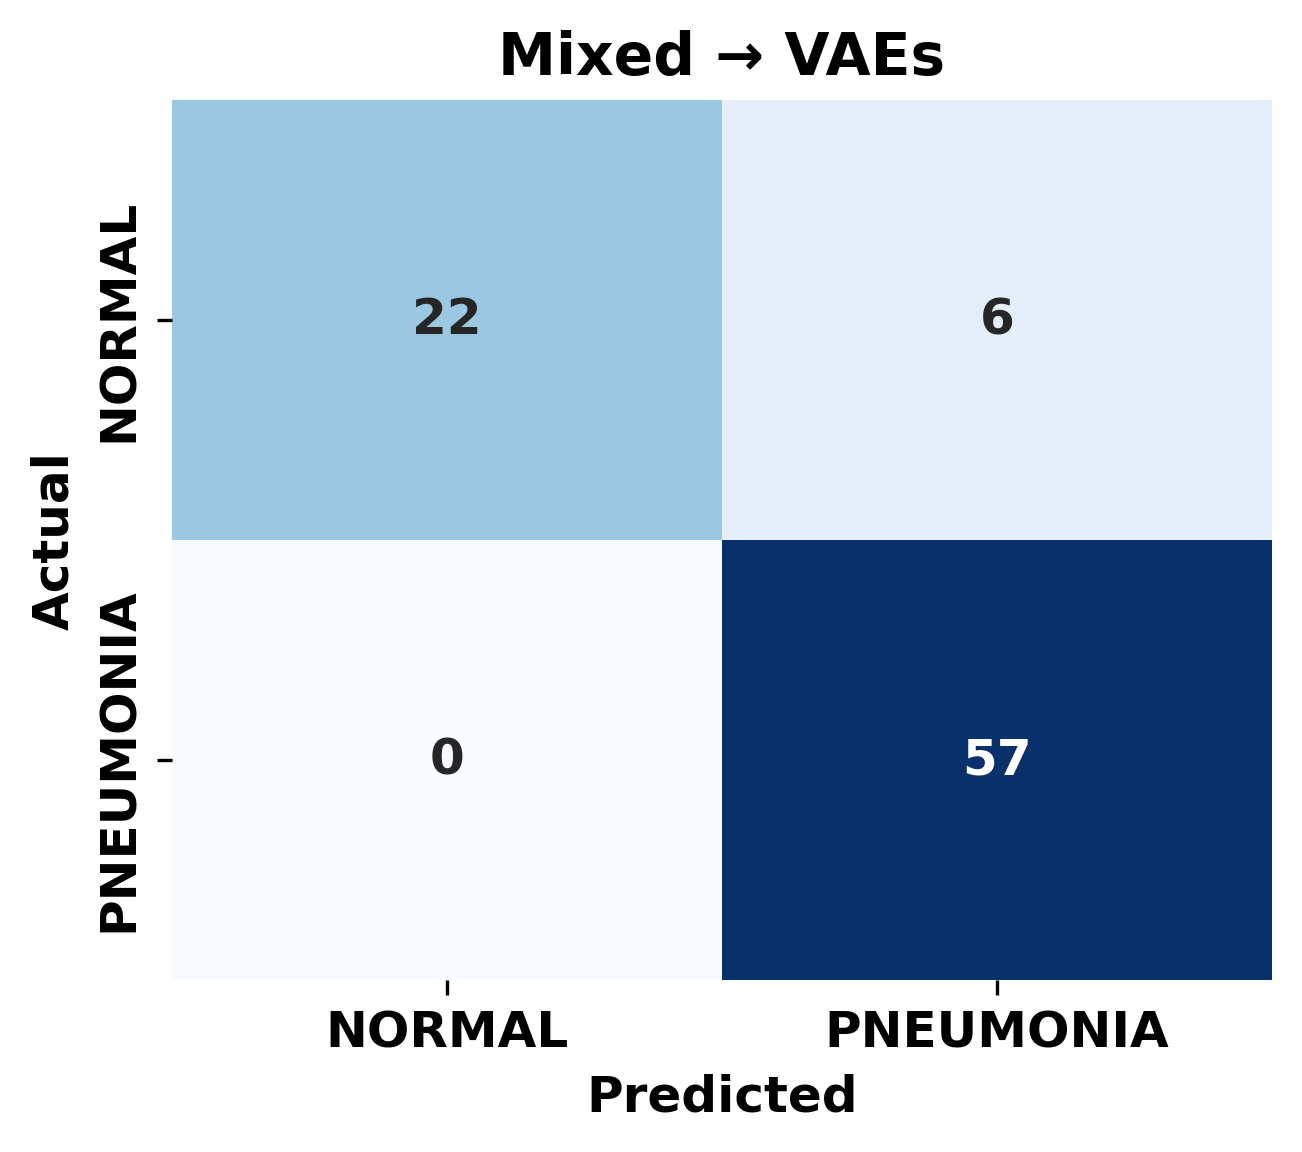

In [31]:
# Confusion matrices
plot_confusion_matrix(metrics_orig[5], metrics_orig[6], train_ds.classes, title="Mixed → Original", save_name="Mixed_Original_CM")
plot_confusion_matrix(metrics_gans[5], metrics_gans[6], train_ds.classes, title="Mixed → GANs", save_name="Mixed_GANs_CM")
plot_confusion_matrix(metrics_vaes[5], metrics_vaes[6], train_ds.classes, title="Mixed → VAEs", save_name="Mixed_VAEs_CM")